## Analise de Internações Hospitalares do SUS

In [387]:
# Importar as Bibliotecas
import pandas as pd
from functools import reduce
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings('ignore')

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [352]:
# configurações
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Parametros Gráfico
rc_params = {'axes.spines.top': False,
             'axes.spines.right': False,
             'legend.fontsize': 8,
             'legend.title_fontsize': 8,
             'legend.loc': 'upper right',
             'legend.fancybox': False,
             'axes.titleweight': 'bold',
             'axes.titlesize': 12,
             'axes.titlepad': 12}
sns.set_theme(style='ticks', rc=rc_params)
sns.set_color_codes('muted')

In [353]:
# Unificação das tabelas
arquivos = ['dados_2018.xlsx', 'dados_2019.xlsx', 'dados_2020.xlsx', 'dados_2021.xlsx', 'dados_2022.xlsx']

Base_Dados = pd.DataFrame()

for arquivo in arquivos:
    xls = pd.ExcelFile(arquivo)  # Abre o arquivo XLSX
    for aba in xls.sheet_names:
        dados = xls.parse(aba)  # Lê a aba
        dados['data'] = aba  # Adiciona uma coluna 'data' com o nome da aba
        Base_Dados = pd.concat([Base_Dados, dados], axis=0)
#Ba
Base_Dados

,uf,frequencia_internacoes,valor_total,valor_servicos_hosp,val_serv_hosp_compl_federal,val_serv_hosp_compl_gestor,valor_servicos_profissionais,val_serv_prof_compl_federal,val_serv_prof_compl_gestor,valor_uti,valor_uci,obitos,dias_permanencia,media_permanencia,taxa_mortalidade,data
0,Rondônia,9446,7998345.94,6377076.74,0.00,0.00,1621269.20,0.00,0.00,2039526.36,197100.00,299,43639,4.62,3.17,jan2018
1,Acre,4608,3576595.19,2735576.57,0.00,0.00,841018.62,0.00,0.00,612282.71,46140.00,128,22117,4.80,2.78,jan2018
2,Amazonas,15074,13572263.03,10398784.99,0.00,0.00,3173478.04,0.00,0.00,2415107.94,301800.00,437,77252,5.12,2.90,jan2018
3,Roraima,3717,2914195.21,2192586.00,0.00,0.00,721609.21,0.00,0.00,567905.05,119808.00,111,19751,5.31,2.99,jan2018
4,Pará,39487,31591185.32,24045989.87,84256.58,0.00,7415881.43,45057.44,0.00,5249417.17,632912.00,930,159161,4.03,2.36,jan2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,Rio Grande do Sul,66813,109386175.22,88101782.92,0.00,0.00,21284392.30,0.00,0.00,26377912.19,576300.00,3456,391433,5.86,5.17,dez2022
23,Mato Grosso do Sul,15868,24267531.21,19009061.40,0.00,0.00,5258469.81,0.00,0.00,6966196.71,404520.00,654,74046,4.67,4.12,dez2022
24,Mato Grosso,17019,19729292.87,15437601.73,0.00,0.00,4291691.14,0.00,0.00,5752290.00,93484.50,514,75428,4.43,3.02,dez2022
25,Goiás,31550,43510820.52,34267292.97,0.00,533308.81,8570040.38,0.00,140178.36,11221365.30,87810.00,1222,153711,4.87,3.87,dez2022


In [354]:
# Base de dados
df = Base_Dados.copy()

# Tratamento de Dados na coluna Data
df['mes'] = df['data'].apply(lambda x: x[0:3])
df['ano'] = df['data'].apply(lambda x: x[-4:])

mes = {'jan': '1', 'fev': '2', 'mar': '3', 'abr': '4', 'mai': '5', 'jun': '6', 'jul': '7', 'ago': '8', 'set': '9', 'out': '10', 'nov': '11', 'dez': '12'}
df['mes'] = df['mes'].replace(mes)

df['data'] = df['ano']+'-'+df['mes']

# Converter para Datetime
df['data'] = pd.to_datetime(df['data'], format='%Y-%m')

df

,uf,frequencia_internacoes,valor_total,valor_servicos_hosp,val_serv_hosp_compl_federal,val_serv_hosp_compl_gestor,valor_servicos_profissionais,val_serv_prof_compl_federal,val_serv_prof_compl_gestor,valor_uti,valor_uci,obitos,dias_permanencia,media_permanencia,taxa_mortalidade,data,mes,ano
0,Rondônia,9446,7998345.94,6377076.74,0.00,0.00,1621269.20,0.00,0.00,2039526.36,197100.00,299,43639,4.62,3.17,2018-01-01,1,2018
1,Acre,4608,3576595.19,2735576.57,0.00,0.00,841018.62,0.00,0.00,612282.71,46140.00,128,22117,4.80,2.78,2018-01-01,1,2018
2,Amazonas,15074,13572263.03,10398784.99,0.00,0.00,3173478.04,0.00,0.00,2415107.94,301800.00,437,77252,5.12,2.90,2018-01-01,1,2018
3,Roraima,3717,2914195.21,2192586.00,0.00,0.00,721609.21,0.00,0.00,567905.05,119808.00,111,19751,5.31,2.99,2018-01-01,1,2018
4,Pará,39487,31591185.32,24045989.87,84256.58,0.00,7415881.43,45057.44,0.00,5249417.17,632912.00,930,159161,4.03,2.36,2018-01-01,1,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,Rio Grande do Sul,66813,109386175.22,88101782.92,0.00,0.00,21284392.30,0.00,0.00,26377912.19,576300.00,3456,391433,5.86,5.17,2022-12-01,12,2022
23,Mato Grosso do Sul,15868,24267531.21,19009061.40,0.00,0.00,5258469.81,0.00,0.00,6966196.71,404520.00,654,74046,4.67,4.12,2022-12-01,12,2022
24,Mato Grosso,17019,19729292.87,15437601.73,0.00,0.00,4291691.14,0.00,0.00,5752290.00,93484.50,514,75428,4.43,3.02,2022-12-01,12,2022
25,Goiás,31550,43510820.52,34267292.97,0.00,533308.81,8570040.38,0.00,140178.36,11221365.30,87810.00,1222,153711,4.87,3.87,2022-12-01,12,2022


In [355]:
# Substituir 0.00 por NaN
df = df.replace(0.00, np.NaN)
df

,uf,frequencia_internacoes,valor_total,valor_servicos_hosp,val_serv_hosp_compl_federal,val_serv_hosp_compl_gestor,valor_servicos_profissionais,val_serv_prof_compl_federal,val_serv_prof_compl_gestor,valor_uti,valor_uci,obitos,dias_permanencia,media_permanencia,taxa_mortalidade,data,mes,ano
0,Rondônia,9446,7998345.94,6377076.74,NaN,NaN,1621269.20,NaN,NaN,2039526.36,197100.00,299,43639,4.62,3.17,2018-01-01,1,2018
1,Acre,4608,3576595.19,2735576.57,NaN,NaN,841018.62,NaN,NaN,612282.71,46140.00,128,22117,4.80,2.78,2018-01-01,1,2018
2,Amazonas,15074,13572263.03,10398784.99,NaN,NaN,3173478.04,NaN,NaN,2415107.94,301800.00,437,77252,5.12,2.90,2018-01-01,1,2018
3,Roraima,3717,2914195.21,2192586.00,NaN,NaN,721609.21,NaN,NaN,567905.05,119808.00,111,19751,5.31,2.99,2018-01-01,1,2018
4,Pará,39487,31591185.32,24045989.87,84256.58,NaN,7415881.43,45057.44,NaN,5249417.17,632912.00,930,159161,4.03,2.36,2018-01-01,1,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,Rio Grande do Sul,66813,109386175.22,88101782.92,NaN,NaN,21284392.30,NaN,NaN,26377912.19,576300.00,3456,391433,5.86,5.17,2022-12-01,12,2022
23,Mato Grosso do Sul,15868,24267531.21,19009061.40,NaN,NaN,5258469.81,NaN,NaN,6966196.71,404520.00,654,74046,4.67,4.12,2022-12-01,12,2022
24,Mato Grosso,17019,19729292.87,15437601.73,NaN,NaN,4291691.14,NaN,NaN,5752290.00,93484.50,514,75428,4.43,3.02,2022-12-01,12,2022
25,Goiás,31550,43510820.52,34267292.97,NaN,533308.81,8570040.38,NaN,140178.36,11221365.30,87810.00,1222,153711,4.87,3.87,2022-12-01,12,2022


In [356]:
# Verificação do dataset
check_df = pd.DataFrame({
                    'type': df.dtypes,
                    'missing': df.isna().sum(),
                    'size': df.shape[0],
                    'unique': df.nunique()})
check_df['percentual_missing'] = round((check_df['missing'] / check_df['size']) * 100, 2)
check_df

,type,missing,size,unique,percentual_missing
uf,object,0,1620,27,0.00
frequencia_internacoes,int64,0,1620,1579,0.00
valor_total,float64,0,1620,1619,0.00
valor_servicos_hosp,float64,0,1620,1619,0.00
val_serv_hosp_compl_federal,float64,806,1620,811,49.75
val_serv_hosp_compl_gestor,float64,1291,1620,322,79.69
valor_servicos_profissionais,float64,0,1620,1619,0.00
val_serv_prof_compl_federal,float64,806,1620,811,49.75
val_serv_prof_compl_gestor,float64,1327,1620,292,81.91
valor_uti,float64,0,1620,1619,0.00


#### Estatistica Descritiva

In [357]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
frequencia_internacoes,1620.00,36451.37,41414.59,640.00,13311.75,18756.00,46165.00,227301.00
valor_total,1620.00,54726606.87,70941317.60,436054.43,15781945.96,27178990.04,71697557.77,527439291.73
valor_servicos_hosp,1620.00,44129081.58,57909435.22,346168.44,12403306.62,21579661.93,57074086.20,439281793.74
val_serv_hosp_compl_federal,814.00,195835.76,380799.59,25.29,14023.64,59528.33,190706.52,3225164.41
val_serv_hosp_compl_gestor,329.00,59200.92,101056.53,110.40,15558.99,31070.52,76827.25,876938.61
valor_servicos_profissionais,1620.00,10423301.31,12844875.38,63625.59,3288596.23,5296823.74,14102317.06,87858391.67
val_serv_prof_compl_federal,814.00,110218.04,216697.40,31.43,7993.47,32780.58,103120.39,1739374.14
val_serv_prof_compl_gestor,293.00,46545.91,88044.10,61.06,7933.28,18372.24,44944.60,741679.79
valor_uti,1620.00,15136789.63,24029420.46,90600.00,3168592.97,6646242.92,16205096.38,257054696.26
valor_uci,1585.00,440185.93,492441.49,360.00,126006.00,273547.50,611370.46,3022875.00


In [358]:
# Substituir NaN por 0
df = df.replace(np.NaN, 0)
df

,uf,frequencia_internacoes,valor_total,valor_servicos_hosp,val_serv_hosp_compl_federal,val_serv_hosp_compl_gestor,valor_servicos_profissionais,val_serv_prof_compl_federal,val_serv_prof_compl_gestor,valor_uti,valor_uci,obitos,dias_permanencia,media_permanencia,taxa_mortalidade,data,mes,ano
0,Rondônia,9446,7998345.94,6377076.74,0.00,0.00,1621269.20,0.00,0.00,2039526.36,197100.00,299,43639,4.62,3.17,2018-01-01,1,2018
1,Acre,4608,3576595.19,2735576.57,0.00,0.00,841018.62,0.00,0.00,612282.71,46140.00,128,22117,4.80,2.78,2018-01-01,1,2018
2,Amazonas,15074,13572263.03,10398784.99,0.00,0.00,3173478.04,0.00,0.00,2415107.94,301800.00,437,77252,5.12,2.90,2018-01-01,1,2018
3,Roraima,3717,2914195.21,2192586.00,0.00,0.00,721609.21,0.00,0.00,567905.05,119808.00,111,19751,5.31,2.99,2018-01-01,1,2018
4,Pará,39487,31591185.32,24045989.87,84256.58,0.00,7415881.43,45057.44,0.00,5249417.17,632912.00,930,159161,4.03,2.36,2018-01-01,1,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,Rio Grande do Sul,66813,109386175.22,88101782.92,0.00,0.00,21284392.30,0.00,0.00,26377912.19,576300.00,3456,391433,5.86,5.17,2022-12-01,12,2022
23,Mato Grosso do Sul,15868,24267531.21,19009061.40,0.00,0.00,5258469.81,0.00,0.00,6966196.71,404520.00,654,74046,4.67,4.12,2022-12-01,12,2022
24,Mato Grosso,17019,19729292.87,15437601.73,0.00,0.00,4291691.14,0.00,0.00,5752290.00,93484.50,514,75428,4.43,3.02,2022-12-01,12,2022
25,Goiás,31550,43510820.52,34267292.97,0.00,533308.81,8570040.38,0.00,140178.36,11221365.30,87810.00,1222,153711,4.87,3.87,2022-12-01,12,2022


In [359]:
aux = df[['data', 'frequencia_internacoes']].groupby('data').sum()
aux.describe().T

,count,mean,std,min,25%,50%,75%,max
frequencia_internacoes,60.00,984186.95,68975.03,788249.00,955961.25,996097.50,1031709.75,1092032.00


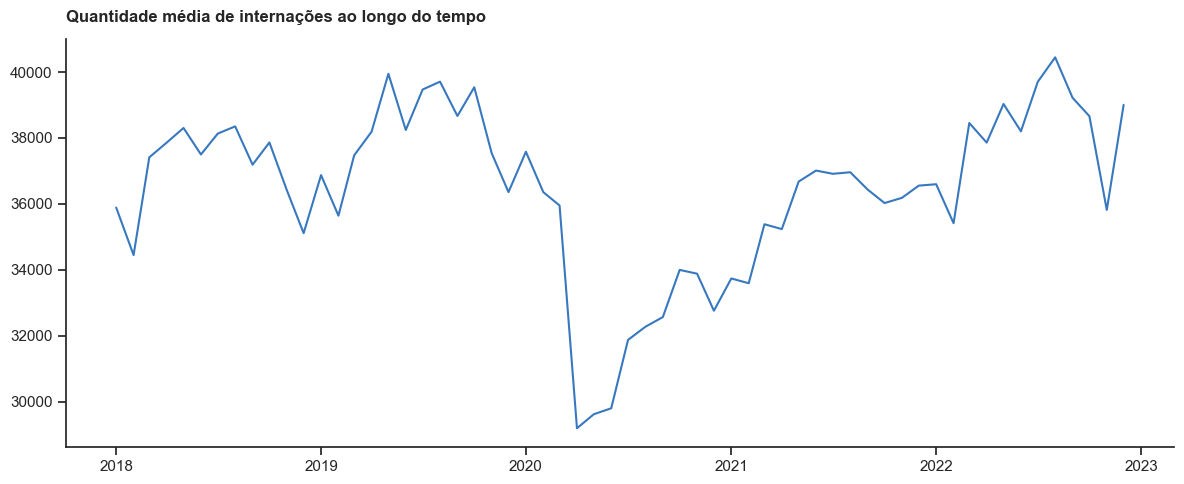

In [360]:
# Quantidade média de internações ao longo do tempo
aux = df[['data', 'frequencia_internacoes']].groupby('data').mean()

ax2 = plt.subplots(figsize=(12, 5))
ax2 = sns.lineplot(x ='data', y = 'frequencia_internacoes', data = aux, color = sns.xkcd_rgb['windows blue'])
plt.title('Quantidade média de internações ao longo do tempo', fontsize=12, loc='left', pad=12)

plt.xlabel('')
plt.ylabel('')
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

### Feature engineering

Adição da coluna de região, valor total de complemento federal e gestor, valor médio de internações e população

In [361]:
# Dicionário de mapeamento de estados para regiões
regioes = {
    'Amazonas': 'Norte', 'Pará': 'Norte', 'Amapá': 'Norte', 'Acre': 'Norte', 'Roraima': 'Norte', 'Rondônia': 'Norte', 'Tocantins': 'Norte',
    'Maranhão': 'Nordeste', 'Piauí': 'Nordeste', 'Ceará': 'Nordeste', 'Rio Grande do Norte': 'Nordeste', 'Paraíba': 'Nordeste', 'Pernambuco': 'Nordeste', 'Sergipe': 'Nordeste', 'Bahia': 'Nordeste', 'Alagoas': 'Nordeste',
    'Mato Grosso': 'Centro Oeste', 'Mato Grosso do Sul': 'Centro Oeste', 'Goiás': 'Centro Oeste', 'Distrito Federal': 'Centro Oeste',
    'Minas Gerais': 'Sudeste', 'Espírito Santo': 'Sudeste', 'Rio de Janeiro': 'Sudeste', 'São Paulo': 'Sudeste',
    'Paraná': 'Sul', 'Santa Catarina': 'Sul', 'Rio Grande do Sul': 'Sul'
}

# Dicionário de mapeamento de sigla do estado para nome do estado
estados = {
    'Acre': 'AC', 'Alagoas': 'AL', 'Amapá': 'AP', 'Amazonas': 'AM', 'Bahia': 'BA', 'Ceará': 'CE', 'Distrito Federal': 'DF',
    'Espírito Santo': 'ES', 'Goiás': 'GO', 'Maranhão': 'MA', 'Mato Grosso': 'MT', 'Mato Grosso do Sul': 'MS',
    'Minas Gerais': 'MG', 'Pará': 'PA', 'Paraíba': 'PB', 'Paraná': 'PR', 'Pernambuco': 'PE', 'Piauí': 'PI',
    'Rio de Janeiro': 'RJ', 'Rio Grande do Norte': 'RN', 'Rio Grande do Sul': 'RS', 'Rondônia': 'RO', 'Roraima': 'RR',
    'Santa Catarina': 'SC', 'São Paulo': 'SP', 'Sergipe': 'SE', 'Tocantins': 'TO'
}

# Aplicar o mapeamento para criar a coluna 'regiao'
df['regiao'] = df['uf'].map(regioes)

# Aplicar o mapeamento para criar a coluna 'sigla_uf'
df['sigla_uf'] = df['uf'].map(estados)


# Total complemento federal
df['total_compl_federal'] = df['val_serv_hosp_compl_federal'] + df['val_serv_prof_compl_federal']

# Total complemento gestor
df['total_compl_gestor'] = df['val_serv_hosp_compl_gestor'] + df['val_serv_prof_compl_gestor']

# Criação de coluna valor_medio_internacao
df['valor_medio_internacao'] = df['valor_total'] / df['frequencia_internacoes']

# Número de leitos ocupados
df['no_leitos_ocupados'] = (df['frequencia_internacoes'] * df['media_permanencia']) / 30

df

,uf,frequencia_internacoes,valor_total,valor_servicos_hosp,val_serv_hosp_compl_federal,val_serv_hosp_compl_gestor,valor_servicos_profissionais,val_serv_prof_compl_federal,val_serv_prof_compl_gestor,valor_uti,valor_uci,obitos,dias_permanencia,media_permanencia,taxa_mortalidade,data,mes,ano,regiao,sigla_uf,total_compl_federal,total_compl_gestor,valor_medio_internacao,no_leitos_ocupados
0,Rondônia,9446,7998345.94,6377076.74,0.00,0.00,1621269.20,0.00,0.00,2039526.36,197100.00,299,43639,4.62,3.17,2018-01-01,1,2018,Norte,RO,0.00,0.00,846.74,1454.63
1,Acre,4608,3576595.19,2735576.57,0.00,0.00,841018.62,0.00,0.00,612282.71,46140.00,128,22117,4.80,2.78,2018-01-01,1,2018,Norte,AC,0.00,0.00,776.17,737.23
2,Amazonas,15074,13572263.03,10398784.99,0.00,0.00,3173478.04,0.00,0.00,2415107.94,301800.00,437,77252,5.12,2.90,2018-01-01,1,2018,Norte,AM,0.00,0.00,900.38,2575.07
3,Roraima,3717,2914195.21,2192586.00,0.00,0.00,721609.21,0.00,0.00,567905.05,119808.00,111,19751,5.31,2.99,2018-01-01,1,2018,Norte,RR,0.00,0.00,784.02,658.37
4,Pará,39487,31591185.32,24045989.87,84256.58,0.00,7415881.43,45057.44,0.00,5249417.17,632912.00,930,159161,4.03,2.36,2018-01-01,1,2018,Norte,PA,129314.02,0.00,800.04,5305.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,Rio Grande do Sul,66813,109386175.22,88101782.92,0.00,0.00,21284392.30,0.00,0.00,26377912.19,576300.00,3456,391433,5.86,5.17,2022-12-01,12,2022,Sul,RS,0.00,0.00,1637.20,13047.77
23,Mato Grosso do Sul,15868,24267531.21,19009061.40,0.00,0.00,5258469.81,0.00,0.00,6966196.71,404520.00,654,74046,4.67,4.12,2022-12-01,12,2022,Centro Oeste,MS,0.00,0.00,1529.34,2468.20
24,Mato Grosso,17019,19729292.87,15437601.73,0.00,0.00,4291691.14,0.00,0.00,5752290.00,93484.50,514,75428,4.43,3.02,2022-12-01,12,2022,Centro Oeste,MT,0.00,0.00,1159.25,2514.27
25,Goiás,31550,43510820.52,34267292.97,0.00,533308.81,8570040.38,0.00,140178.36,11221365.30,87810.00,1222,153711,4.87,3.87,2022-12-01,12,2022,Centro Oeste,GO,0.00,673487.17,1379.11,5123.70


In [362]:
# População de cada estado - Dados extraidos do IBGE
populacao = pd.read_excel('populacao.xlsx') 
populacao.columns = ['uf', '2018', '2019', '2020', '2021', '2022']

# Unificação dos datasets trazendo a população de cada estado
df = df.merge(populacao, how='inner', on='uf')

# Adicionando a coluna população com base no ano correspondente
for ano in ['2018', '2019', '2020', '2021', '2022']:
    df.loc[df['ano'] == ano, 'populacao'] = df[ano]

# Elimine as colunas não necessária
df = df.drop(columns=['2018', '2019', '2020', '2021', '2022'])
df 

,uf,frequencia_internacoes,valor_total,valor_servicos_hosp,val_serv_hosp_compl_federal,val_serv_hosp_compl_gestor,valor_servicos_profissionais,val_serv_prof_compl_federal,val_serv_prof_compl_gestor,valor_uti,valor_uci,obitos,dias_permanencia,media_permanencia,taxa_mortalidade,data,mes,ano,regiao,sigla_uf,total_compl_federal,total_compl_gestor,valor_medio_internacao,no_leitos_ocupados,populacao
0,Rondônia,9446,7998345.94,6377076.74,0.00,0.00,1621269.20,0.00,0.00,2039526.36,197100.00,299,43639,4.62,3.17,2018-01-01,1,2018,Norte,RO,0.00,0.00,846.74,1454.63,1757589.00
1,Rondônia,9930,8893683.69,7151582.11,0.00,0.00,1742101.58,0.00,0.00,2357091.26,164520.00,301,48434,4.88,3.03,2018-02-01,2,2018,Norte,RO,0.00,0.00,895.64,1614.47,1757589.00
2,Rondônia,10315,8867793.32,7116826.21,0.00,0.00,1750967.11,0.00,0.00,2404341.07,157500.00,289,48101,4.66,2.80,2018-03-01,3,2018,Norte,RO,0.00,0.00,859.70,1603.37,1757589.00
3,Rondônia,10290,8871408.50,7110636.40,0.00,0.00,1760772.10,0.00,0.00,2099480.17,131760.00,286,47175,4.58,2.78,2018-04-01,4,2018,Norte,RO,0.00,0.00,862.14,1572.50,1757589.00
4,Rondônia,10537,8501601.67,6815434.95,0.00,0.00,1686166.72,0.00,0.00,2125564.43,156420.00,283,45849,4.35,2.69,2018-05-01,5,2018,Norte,RO,0.00,0.00,806.83,1528.30,1757589.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,Distrito Federal,21242,30312743.67,24550790.58,0.00,0.00,5761953.09,0.00,0.00,7070962.58,126006.00,625,129549,6.10,2.94,2022-08-01,8,2022,Centro Oeste,DF,0.00,0.00,1427.02,4318.30,2923369.00
1616,Distrito Federal,19172,27630817.49,22418782.23,0.00,0.00,5212035.26,0.00,0.00,7316607.07,109776.00,598,113692,5.93,3.12,2022-09-01,9,2022,Centro Oeste,DF,0.00,0.00,1441.21,3789.73,2923369.00
1617,Distrito Federal,20207,28410115.62,22805242.90,0.00,0.00,5604872.72,0.00,0.00,7076475.89,106278.00,634,114044,5.64,3.14,2022-10-01,10,2022,Centro Oeste,DF,0.00,0.00,1405.95,3801.47,2923369.00
1618,Distrito Federal,20153,26510116.49,21267444.77,0.00,0.00,5242671.72,0.00,0.00,6293813.15,75024.00,540,117081,5.81,2.68,2022-11-01,11,2022,Centro Oeste,DF,0.00,0.00,1315.44,3902.70,2923369.00


In [363]:
# Base dados tratada
df1 = df[['data', 'mes', 'ano', 'uf', 'sigla_uf', 'regiao', 'populacao', 'frequencia_internacoes', 'valor_total', 'valor_servicos_hosp', 'val_serv_hosp_compl_federal', 
          'val_serv_hosp_compl_gestor', 'valor_servicos_profissionais', 'val_serv_prof_compl_federal', 'val_serv_prof_compl_gestor', 'total_compl_federal',	'total_compl_gestor', 
          'valor_medio_internacao', 'dias_permanencia', 'media_permanencia', 'no_leitos_ocupados', 'obitos', 'taxa_mortalidade']]
df1

,data,mes,ano,uf,sigla_uf,regiao,populacao,frequencia_internacoes,valor_total,valor_servicos_hosp,val_serv_hosp_compl_federal,val_serv_hosp_compl_gestor,valor_servicos_profissionais,val_serv_prof_compl_federal,val_serv_prof_compl_gestor,total_compl_federal,total_compl_gestor,valor_medio_internacao,dias_permanencia,media_permanencia,no_leitos_ocupados,obitos,taxa_mortalidade
0,2018-01-01,1,2018,Rondônia,RO,Norte,1757589.00,9446,7998345.94,6377076.74,0.00,0.00,1621269.20,0.00,0.00,0.00,0.00,846.74,43639,4.62,1454.63,299,3.17
1,2018-02-01,2,2018,Rondônia,RO,Norte,1757589.00,9930,8893683.69,7151582.11,0.00,0.00,1742101.58,0.00,0.00,0.00,0.00,895.64,48434,4.88,1614.47,301,3.03
2,2018-03-01,3,2018,Rondônia,RO,Norte,1757589.00,10315,8867793.32,7116826.21,0.00,0.00,1750967.11,0.00,0.00,0.00,0.00,859.70,48101,4.66,1603.37,289,2.80
3,2018-04-01,4,2018,Rondônia,RO,Norte,1757589.00,10290,8871408.50,7110636.40,0.00,0.00,1760772.10,0.00,0.00,0.00,0.00,862.14,47175,4.58,1572.50,286,2.78
4,2018-05-01,5,2018,Rondônia,RO,Norte,1757589.00,10537,8501601.67,6815434.95,0.00,0.00,1686166.72,0.00,0.00,0.00,0.00,806.83,45849,4.35,1528.30,283,2.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,2022-08-01,8,2022,Distrito Federal,DF,Centro Oeste,2923369.00,21242,30312743.67,24550790.58,0.00,0.00,5761953.09,0.00,0.00,0.00,0.00,1427.02,129549,6.10,4318.30,625,2.94
1616,2022-09-01,9,2022,Distrito Federal,DF,Centro Oeste,2923369.00,19172,27630817.49,22418782.23,0.00,0.00,5212035.26,0.00,0.00,0.00,0.00,1441.21,113692,5.93,3789.73,598,3.12
1617,2022-10-01,10,2022,Distrito Federal,DF,Centro Oeste,2923369.00,20207,28410115.62,22805242.90,0.00,0.00,5604872.72,0.00,0.00,0.00,0.00,1405.95,114044,5.64,3801.47,634,3.14
1618,2022-11-01,11,2022,Distrito Federal,DF,Centro Oeste,2923369.00,20153,26510116.49,21267444.77,0.00,0.00,5242671.72,0.00,0.00,0.00,0.00,1315.44,117081,5.81,3902.70,540,2.68


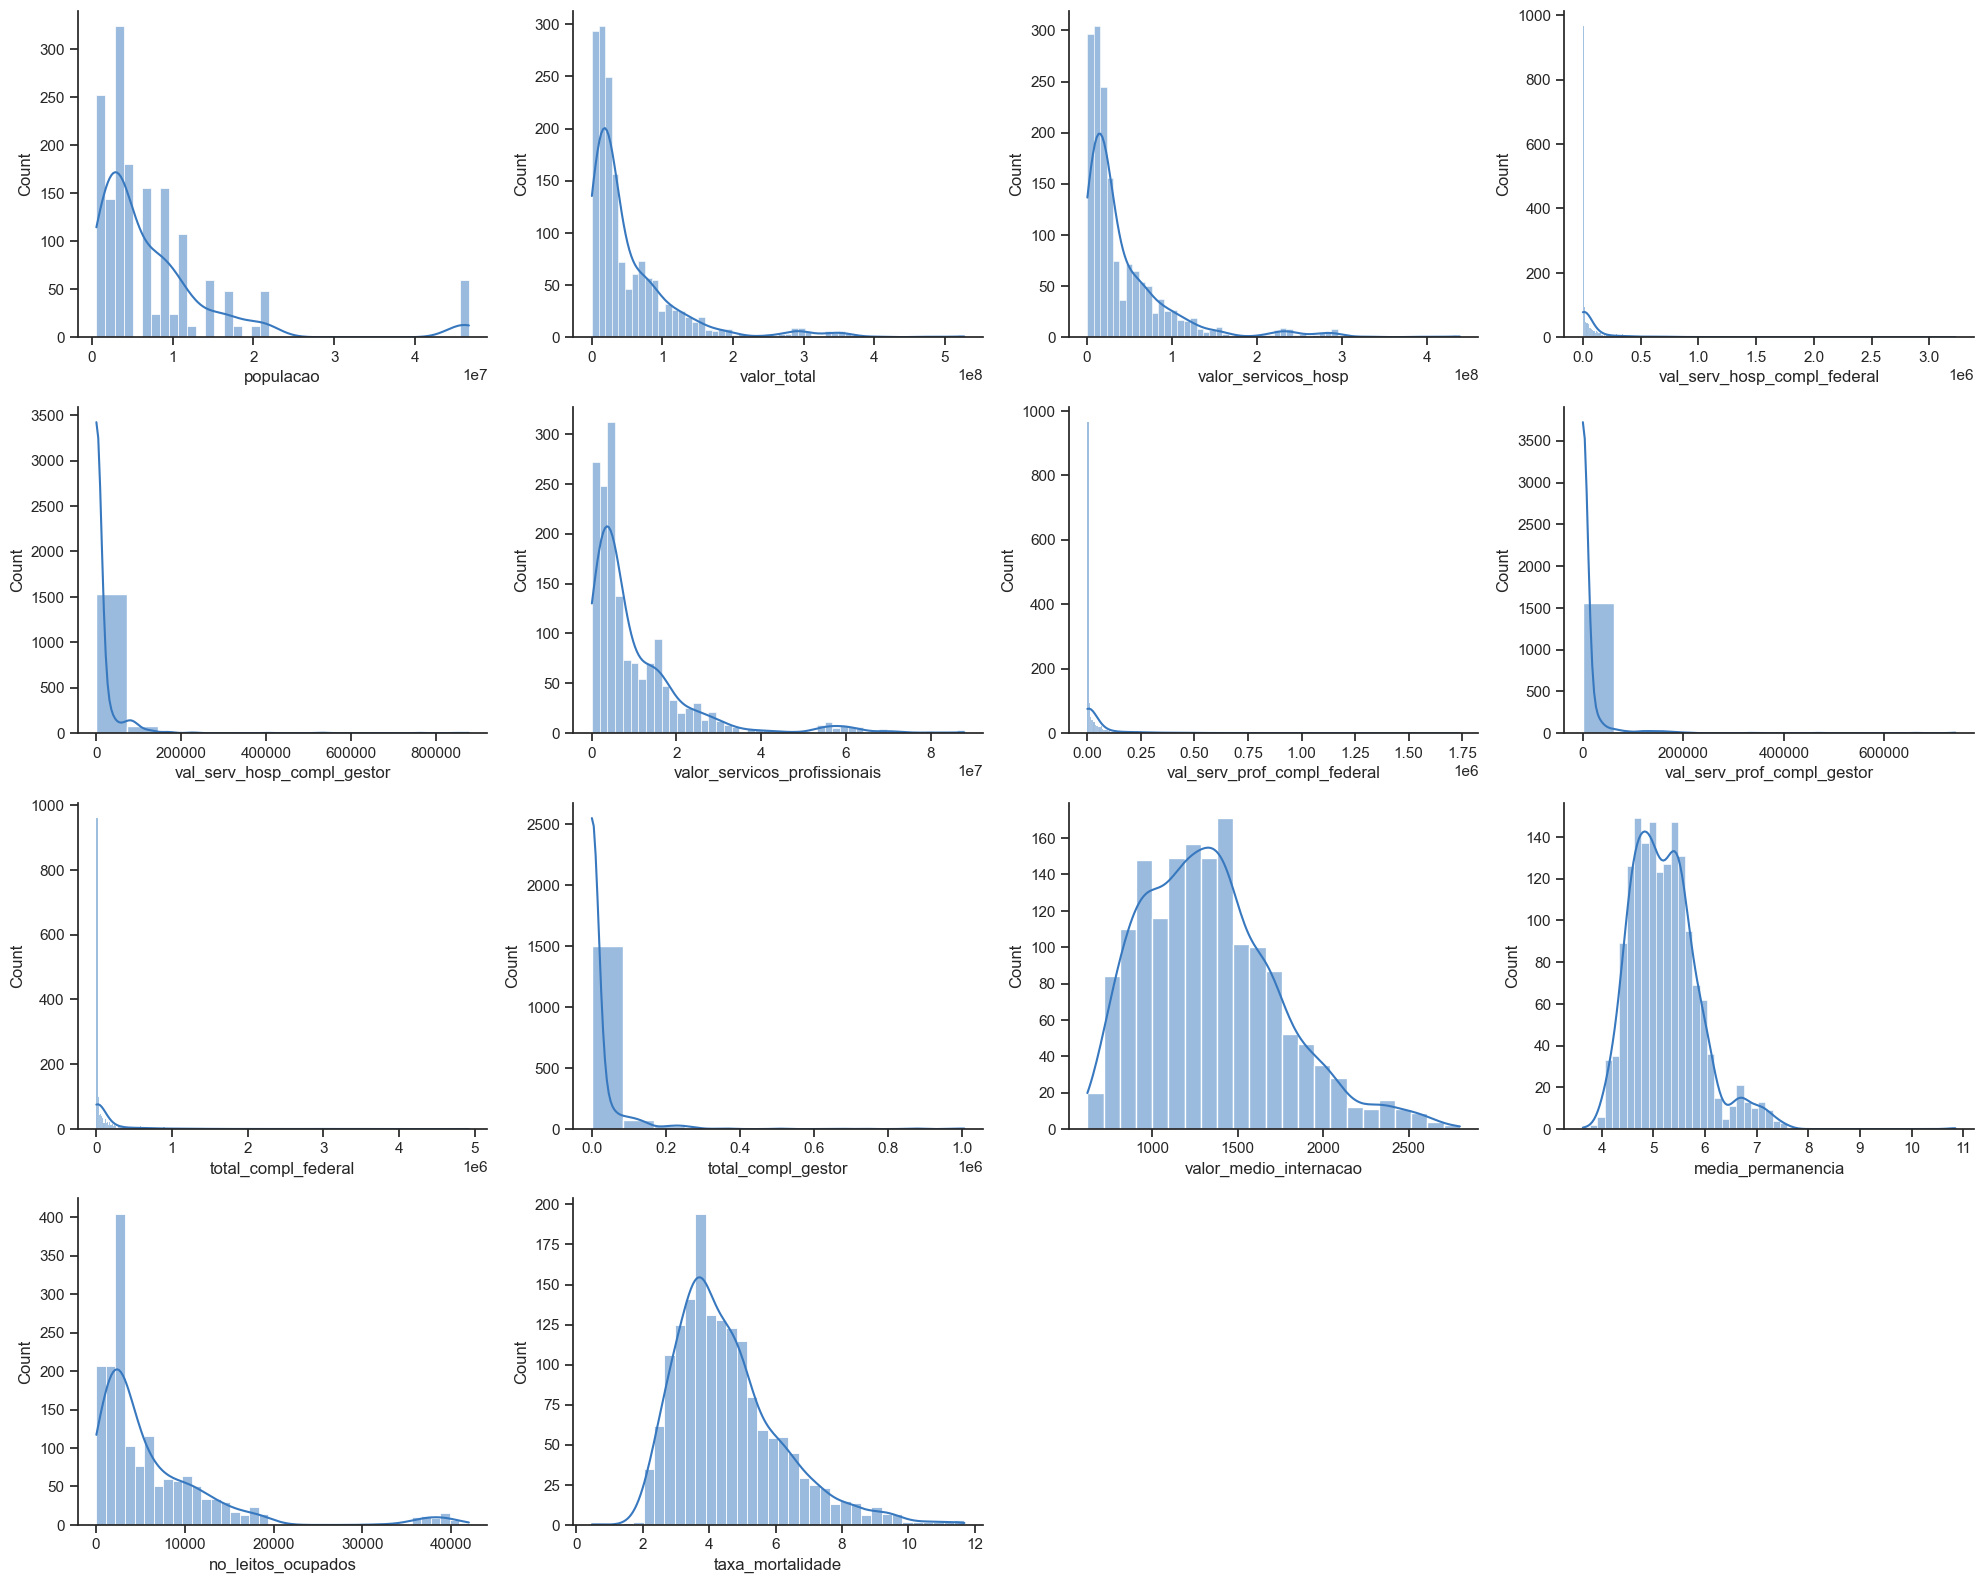

In [364]:
from matplotlib.ticker import ScalarFormatter
# Selecionar colunas numéricas
num_features = [col for col in df1.columns if df1[col].dtype == 'float64']

# Configurar o número de linhas e colunas para os subplots
num_rows = len(num_features) // 4 + 1  # Você pode ajustar o número de colunas por linha conforme necessário
num_cols = 4

# Criar uma figura com subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 4*num_rows), constrained_layout=True)

# Loop através das colunas numéricas e criar um histograma em cada subplot
for i, feature in enumerate(num_features):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    sns.histplot(data=df1, x=feature, kde=True, color=sns.xkcd_rgb['windows blue'], ax=ax)

# Remover subplots vazios (se houver)
for i in range(len(num_features), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()


### Teste de Hipóteses

#### Teste de taxa de mortalidade entre as regiões

Hipótese nula (H0): A média da taxa de mortalidade é a mesma em todas as regiões do Brasil.

Hipótese alternativa (H1): A média da taxa de mortalidade difere entre as regiões do Brasil.

In [365]:
from scipy.stats import f_oneway

# Dados
regioes = df1['regiao'].unique()
grupos = [df1[df1['regiao'] == regiao]['taxa_mortalidade'] for regiao in regioes]

# Teste ANOVA
statistic, p_value = f_oneway(*grupos)

# Resultados
alpha = 0.05
print("Teste ANOVA - Média de taxa de mortalidade nas regiões:")
print(f"Estatística F: {statistic}")
print(f"Valor P: {p_value}")
if p_value < alpha:
    print("Rejeitamos a hipótese nula (H0)")
else:
    print("Não rejeitamos a hipótese nula (H0)")


Teste ANOVA - Média de taxa de mortalidade nas regiões:
Estatística F: 104.3249664333099
Valor P: 4.1820622570359254e-79
Rejeitamos a hipótese nula (H0)


### Teste de correlação

Hipótese nula (H0): Não há correlação entre a população e a frequência de internações.

Hipótese alternativa (H1): Existe uma correlação significativa entre a população e a frequência de internações.

In [366]:
from scipy.stats import pearsonr

# Agrupe os dados por UF e calcule a correlação entre população e frequência de internações para cada UF
correlations = df1.groupby('uf').apply(lambda group: pearsonr(group['populacao'], group['frequencia_internacoes']))

# Resultados
alpha = 0.05
for uf, (correlation, p_value) in correlations.iteritems():
    print(f"UF: {uf}")
    print("Teste de correlação de Pearson - População vs. Frequência de Internações:")
    print(f"Coeficiente de correlação: {correlation}")
    print(f"Valor P: {p_value}")
    if p_value < alpha:
        print("Há uma correlação significativa")
    else:
        print("Não há correlação significativa")
    print()

UF: Acre
Teste de correlação de Pearson - População vs. Frequência de Internações:
Coeficiente de correlação: -0.16690477789099334
Valor P: 0.20244909815304987
Não há correlação significativa

UF: Alagoas
Teste de correlação de Pearson - População vs. Frequência de Internações:
Coeficiente de correlação: 0.10908386737971702
Valor P: 0.40672802980259665
Não há correlação significativa

UF: Amapá
Teste de correlação de Pearson - População vs. Frequência de Internações:
Coeficiente de correlação: -0.28647968789334227
Valor P: 0.02647856763376407
Há uma correlação significativa

UF: Amazonas
Teste de correlação de Pearson - População vs. Frequência de Internações:
Coeficiente de correlação: 0.024113768133838438
Valor P: 0.8548907757436357
Não há correlação significativa

UF: Bahia
Teste de correlação de Pearson - População vs. Frequência de Internações:
Coeficiente de correlação: -0.43965436979148986
Valor P: 0.0004402082849418885
Há uma correlação significativa

UF: Ceará
Teste de correla

#### Taxa de mortalidade entre as regiões

Hipótese Nula (H0): Não há diferença significativa na taxa de mortalidade entre as regiões Sudeste e Nordeste.

Hipótese Alternativa (H1): Há uma diferença significativa na taxa de mortalidade entre as regiões Sudeste e Nordeste.

In [367]:
import scipy.stats as stats

# Filtrando os dados para as duas regiões de interesse
regiao_sudeste = df1[df1['regiao'] == 'Sudeste']
regiao_nordeste = df1[df1['regiao'] == 'Nordeste']

# Definindo as amostras
amostra_sudeste = regiao_sudeste['taxa_mortalidade']
amostra_nordeste = regiao_nordeste['taxa_mortalidade']

# Realizando o teste t-student
t_stat, p_value = stats.ttest_ind(amostra_sudeste, amostra_nordeste, equal_var=False)

# Definindo um nível de significância (alfa)
alfa = 0.05

# Verificando o resultado do teste
print(f"Teste t-student: {t_stat}")
print(f"Valor P: {p_value}")
if p_value < alfa:
    print(f'Rejeitamos a hipótese nula (H0). Há uma diferença significativa na taxa de mortalidade entre as regiões Sudeste e Nordeste.')
else:
    print(f'Não temos evidências para rejeitar a hipótese nula (H0). Não há uma diferença significativa na taxa de mortalidade entre as regiões Sudeste e Nordeste.')



Teste t-student: 10.592527534411698
Valor P: 4.7641371407684654e-23
Rejeitamos a hipótese nula (H0). Há uma diferença significativa na taxa de mortalidade entre as regiões Sudeste e Nordeste.


#### Comparação das médias de permanência em hospitais entre dois Estados
Hipótese Nula (H0): Não há diferença significativa na média de permanência em hospitais entre os estados de São Paulo e Rio de Janeiro.

Hipótese Alternativa (H1): Há uma diferença significativa na média de permanência em hospitais entre os estados de São Paulo e Rio de Janeiro.

In [368]:
# Filtrando os dados para os dois estados de interesse
estado_sp = df1[df1['uf'] == 'São Paulo']
estado_rj = df1[df1['uf'] == 'Rio de Janeiro']

# Definindo as amostras
amostra_sp = estado_sp['dias_permanencia']
amostra_rj = estado_rj['dias_permanencia']

# Realizando o teste t-student
t_stat, p_value = stats.ttest_ind(amostra_sp, amostra_rj, equal_var=False)

# Definindo um nível de significância (alfa)
alfa = 0.05

# Verificando o resultado do teste
print(f"Teste t-student: {t_stat}")
print(f"Valor P: {p_value}")
if p_value < alfa:
    print(f'Rejeitamos a hipótese nula (H0). Há uma diferença significativa na média de permanência em hospitais entre São Paulo e Rio de Janeiro.')
else:
    print(f'Não temos evidências para rejeitar a hipótese nula (H0). Não há uma diferença significativa na média de permanência em hospitais entre São Paulo e Rio de Janeiro.')


Teste t-student: 82.91563811888119
Valor P: 3.1109873232017075e-80
Rejeitamos a hipótese nula (H0). Há uma diferença significativa na média de permanência em hospitais entre São Paulo e Rio de Janeiro.


#### Comparação das médias de valores de serviços profissionais entre dois anos

Hipótese Nula (H0): Não há diferença significativa na média dos valores de serviços profissionais entre os anos de 2020 e 2021.

Hipótese Alternativa (H1): Há uma diferença significativa na média dos valores de serviços profissionais entre os anos de 2020 e 2021.

In [369]:
# Filtrando os dados para os dois anos de interesse
ano_2020 = df1[df1['ano'] == '2020']
ano_2021 = df1[df1['ano'] == '2021']

# Definindo as amostras
amostra_2020 = ano_2020['valor_servicos_profissionais']
amostra_2021 = ano_2021['valor_servicos_profissionais']

# Realizando o teste t-student
t_stat, p_value = stats.ttest_ind(amostra_2020, amostra_2021, equal_var=False)

# Definindo um nível de significância (alfa)
alfa = 0.05

# Verificando o resultado do teste
print(f"Teste t-student: {t_stat}")
print(f"Valor P: {p_value}")
if p_value < alfa:
    print(f'Rejeitamos a hipótese nula (H0). Há uma diferença significativa na média dos valores de serviços profissionais entre 2020 e 2021.')
else:
    print(f'Não temos evidências para rejeitar a hipótese nula (H0). Não há uma diferença significativa na média dos valores de serviços profissionais entre 2020 e 2021.')


Teste t-student: -2.626760527413164
Valor P: 0.008836852613858488
Rejeitamos a hipótese nula (H0). Há uma diferença significativa na média dos valores de serviços profissionais entre 2020 e 2021.


#### Comparação das médias de valor total de internações entre duas regiões

Hipótese Nula (H0): Não há diferença significativa na média dos valores totais das internações entre a Região Sul e a Região Centro-Oeste.

Hipótese Alternativa (H1): Há uma diferença significativa na média dos valores totais das internações entre a Região Sul e a Região Centro-Oeste.

In [370]:
# Filtrando os dados para as duas regiões de interesse
regiao_sul = df1[df1['regiao'] == 'Sul']
regiao_centro_oeste = df1[df1['regiao'] == 'Centro Oeste']

# Definindo as amostras
amostra_sul = regiao_sul['valor_total']
amostra_centro_oeste = regiao_centro_oeste['valor_total']

# Realizando o teste t-student
t_stat, p_value = stats.ttest_ind(amostra_sul, amostra_centro_oeste, equal_var=False)

# Definindo um nível de significância (alfa)
alfa = 0.05

# Verificando o resultado do teste
print(f"Teste t-student: {t_stat}")
print(f"Valor P: {p_value}")
if p_value < alfa:
    print(f'Rejeitamos a hipótese nula (H0). Há uma diferença significativa na média dos valores totais das internações entre a Região Sul e a Região Centro-Oeste.')
else:
    print(f'Não temos evidências para rejeitar a hipótese nula (H0). Não há uma diferença significativa na média dos valores totais das internações entre a Região Sul e a Região Centro-Oeste.')


Teste t-student: 32.54430312135175
Valor P: 9.928814565241689e-86
Rejeitamos a hipótese nula (H0). Há uma diferença significativa na média dos valores totais das internações entre a Região Sul e a Região Centro-Oeste.


#### Teste não paramétrico

In [371]:
from scipy.stats import mannwhitneyu

# Filtrando os dados para as duas regiões de interesse
regiao_sul = df1[df1['regiao'] == 'Sul']
regiao_centro_oeste = df1[df1['regiao'] == 'Centro Oeste']

# Definindo as amostras
amostra_sul = regiao_sul['valor_total']
amostra_centro_oeste = regiao_centro_oeste['valor_total']

# Realizando o teste de Mann-Whitney U
stat, p_value = mannwhitneyu(amostra_sul, amostra_centro_oeste)

# Definindo um nível de significância (alfa)
alfa = 0.05

# Verificando o resultado do teste
print(f"Teste de Mann-Whitney U: {stat}")
print(f"Valor P: {p_value}")
if p_value < alfa:
    print(f'Rejeitamos a hipótese nula (H0). Há uma diferença significativa nos valores totais das internações entre a Região Sul e a Região Centro-Oeste.')
else:
    print(f'Não temos evidências para rejeitar a hipótese nula (H0). Não há uma diferença significativa nos valores totais das internações entre a Região Sul e a Região Centro-Oeste.')


Teste de Mann-Whitney U: 43017.0
Valor P: 8.804957889043198e-68
Rejeitamos a hipótese nula (H0). Há uma diferença significativa nos valores totais das internações entre a Região Sul e a Região Centro-Oeste.


### Análise Exploratória

In [372]:
# Base dados tratada
df1 = df[['data', 'mes', 'ano', 'uf', 'sigla_uf', 'regiao', 'populacao', 'frequencia_internacoes', 'valor_total', 'valor_servicos_hosp', 'val_serv_hosp_compl_federal', 
          'val_serv_hosp_compl_gestor', 'valor_servicos_profissionais', 'val_serv_prof_compl_federal', 'val_serv_prof_compl_gestor', 'total_compl_federal',	'total_compl_gestor', 
          'valor_medio_internacao', 'dias_permanencia', 'media_permanencia', 'no_leitos_ocupados', 'obitos', 'taxa_mortalidade']]
df1

,data,mes,ano,uf,sigla_uf,regiao,populacao,frequencia_internacoes,valor_total,valor_servicos_hosp,val_serv_hosp_compl_federal,val_serv_hosp_compl_gestor,valor_servicos_profissionais,val_serv_prof_compl_federal,val_serv_prof_compl_gestor,total_compl_federal,total_compl_gestor,valor_medio_internacao,dias_permanencia,media_permanencia,no_leitos_ocupados,obitos,taxa_mortalidade
0,2018-01-01,1,2018,Rondônia,RO,Norte,1757589.00,9446,7998345.94,6377076.74,0.00,0.00,1621269.20,0.00,0.00,0.00,0.00,846.74,43639,4.62,1454.63,299,3.17
1,2018-02-01,2,2018,Rondônia,RO,Norte,1757589.00,9930,8893683.69,7151582.11,0.00,0.00,1742101.58,0.00,0.00,0.00,0.00,895.64,48434,4.88,1614.47,301,3.03
2,2018-03-01,3,2018,Rondônia,RO,Norte,1757589.00,10315,8867793.32,7116826.21,0.00,0.00,1750967.11,0.00,0.00,0.00,0.00,859.70,48101,4.66,1603.37,289,2.80
3,2018-04-01,4,2018,Rondônia,RO,Norte,1757589.00,10290,8871408.50,7110636.40,0.00,0.00,1760772.10,0.00,0.00,0.00,0.00,862.14,47175,4.58,1572.50,286,2.78
4,2018-05-01,5,2018,Rondônia,RO,Norte,1757589.00,10537,8501601.67,6815434.95,0.00,0.00,1686166.72,0.00,0.00,0.00,0.00,806.83,45849,4.35,1528.30,283,2.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,2022-08-01,8,2022,Distrito Federal,DF,Centro Oeste,2923369.00,21242,30312743.67,24550790.58,0.00,0.00,5761953.09,0.00,0.00,0.00,0.00,1427.02,129549,6.10,4318.30,625,2.94
1616,2022-09-01,9,2022,Distrito Federal,DF,Centro Oeste,2923369.00,19172,27630817.49,22418782.23,0.00,0.00,5212035.26,0.00,0.00,0.00,0.00,1441.21,113692,5.93,3789.73,598,3.12
1617,2022-10-01,10,2022,Distrito Federal,DF,Centro Oeste,2923369.00,20207,28410115.62,22805242.90,0.00,0.00,5604872.72,0.00,0.00,0.00,0.00,1405.95,114044,5.64,3801.47,634,3.14
1618,2022-11-01,11,2022,Distrito Federal,DF,Centro Oeste,2923369.00,20153,26510116.49,21267444.77,0.00,0.00,5242671.72,0.00,0.00,0.00,0.00,1315.44,117081,5.81,3902.70,540,2.68


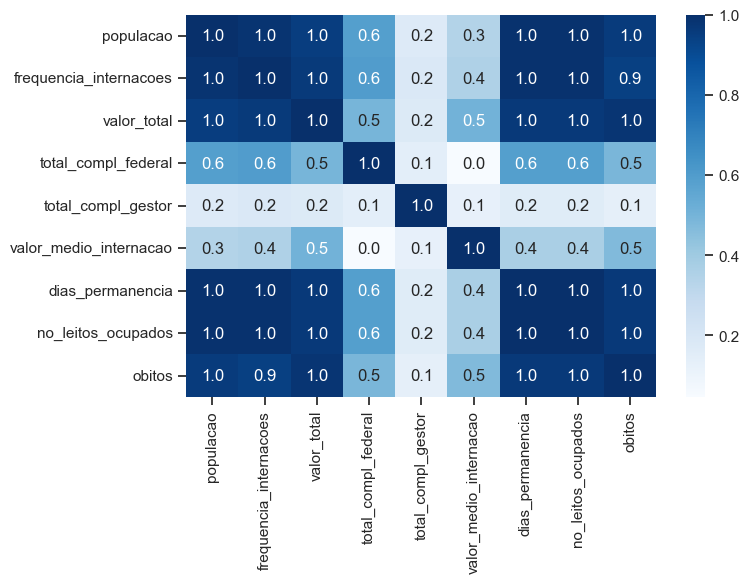

In [373]:
# Gráfico de Correlação

df_corr = df1[['populacao', 'frequencia_internacoes', 'valor_total', 
           'total_compl_federal',	'total_compl_gestor', 
          'valor_medio_internacao', 'dias_permanencia', 'no_leitos_ocupados', 'obitos']]

plt.figure(figsize = (8, 6))
sns.heatmap(df_corr.corr(), cmap='Blues', annot=True, fmt="1.1f")
#plt.title('Correlação', fontsize=12, loc='left', pad=12)
plt.tight_layout()
plt.show()

In [374]:
df_corr.corr()

,populacao,frequencia_internacoes,valor_total,total_compl_federal,total_compl_gestor,valor_medio_internacao,dias_permanencia,no_leitos_ocupados,obitos
populacao,1.00,0.98,0.95,0.59,0.17,0.34,0.99,0.99,0.96
frequencia_internacoes,0.98,1.00,0.96,0.60,0.19,0.35,0.99,0.99,0.94
valor_total,0.95,0.96,1.00,0.49,0.18,0.51,0.96,0.96,0.98
total_compl_federal,0.59,0.60,0.49,1.00,0.14,0.05,0.59,0.59,0.49
total_compl_gestor,0.17,0.19,0.18,0.14,1.00,0.12,0.16,0.16,0.13
valor_medio_internacao,0.34,0.35,0.51,0.05,0.12,1.00,0.37,0.37,0.47
dias_permanencia,0.99,0.99,0.96,0.59,0.16,0.37,1.00,1.00,0.97
no_leitos_ocupados,0.99,0.99,0.96,0.59,0.16,0.37,1.00,1.00,0.97
obitos,0.96,0.94,0.98,0.49,0.13,0.47,0.97,0.97,1.00


#### Valor Total de Internações

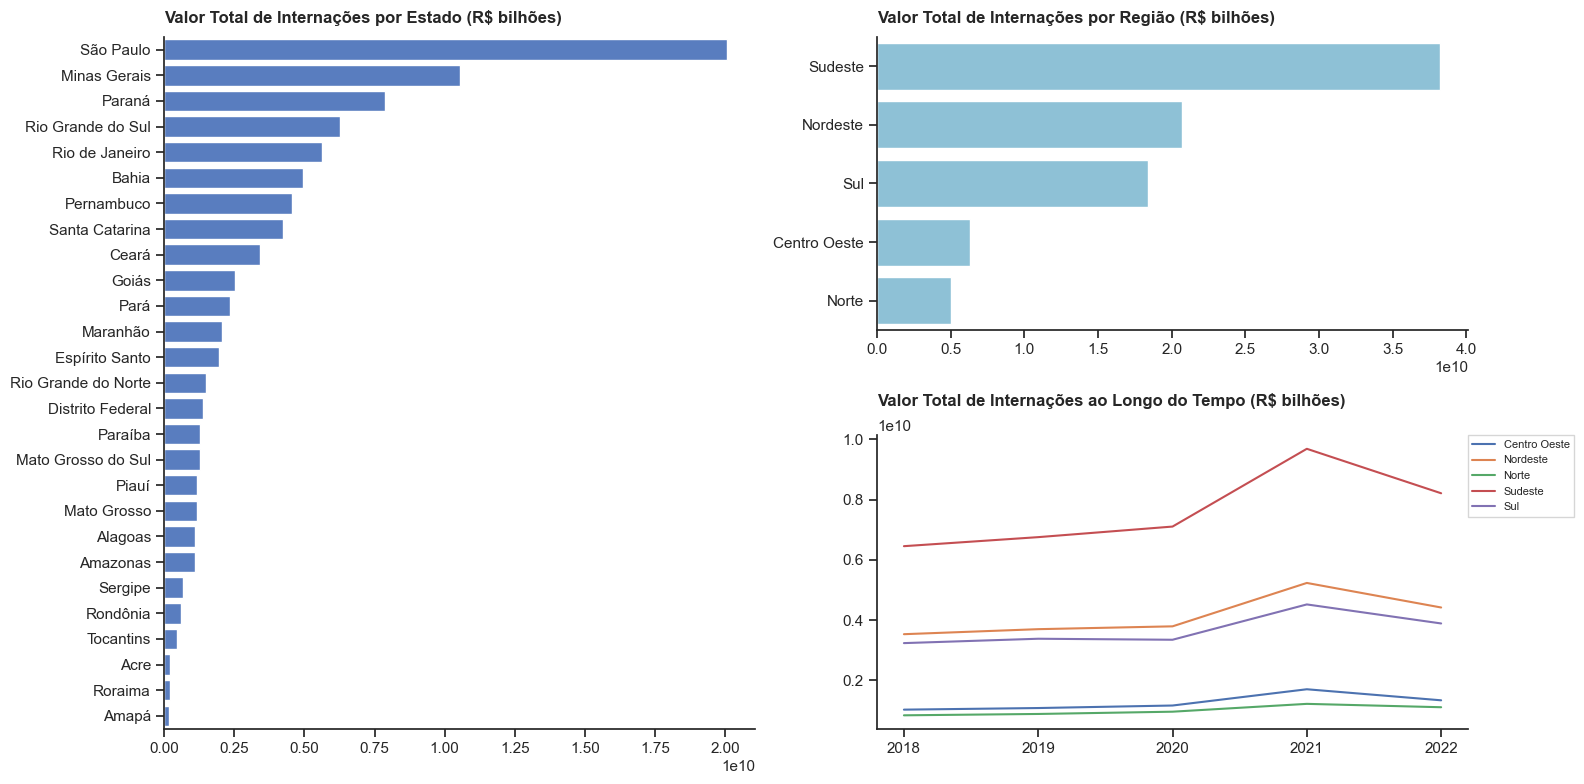

In [375]:
fig1, ax1 = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), constrained_layout=True)

plt.subplot(2, 2, (1,3))
aux1 = df1[['ano', 'uf', 'valor_total']].groupby('uf').sum().sort_values(by='valor_total', ascending=False).reset_index()
sns.barplot(x='valor_total', y='uf', data=aux1, color='b')
plt.title('Valor Total de Internações por Estado (R$ bilhões)', fontsize=12, loc='left', pad=10)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 2)
aux2 = df1[['regiao', 'valor_total']].groupby('regiao').sum().sort_values(by='valor_total', ascending=False).reset_index()
sns.barplot(x='valor_total', y='regiao', data=aux2, color='c')
plt.title('Valor Total de Internações por Região (R$ bilhões)', fontsize=12, loc='left', pad=10)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 4)
aux3 = df1[['ano', 'regiao', 'valor_total']].groupby(['ano', 'regiao']).sum().sort_values(by='ano', ascending=True).reset_index()
sns.lineplot(x='ano', y='valor_total', hue='regiao', data=aux3)
plt.title('Valor Total de Internações ao Longo do Tempo (R$ bilhões)', fontsize=12, loc='left', pad=10)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('')
plt.ylabel('')

plt.tight_layout()
plt.show()

#### Valor Médio dos Serviços Profissionais por Estado

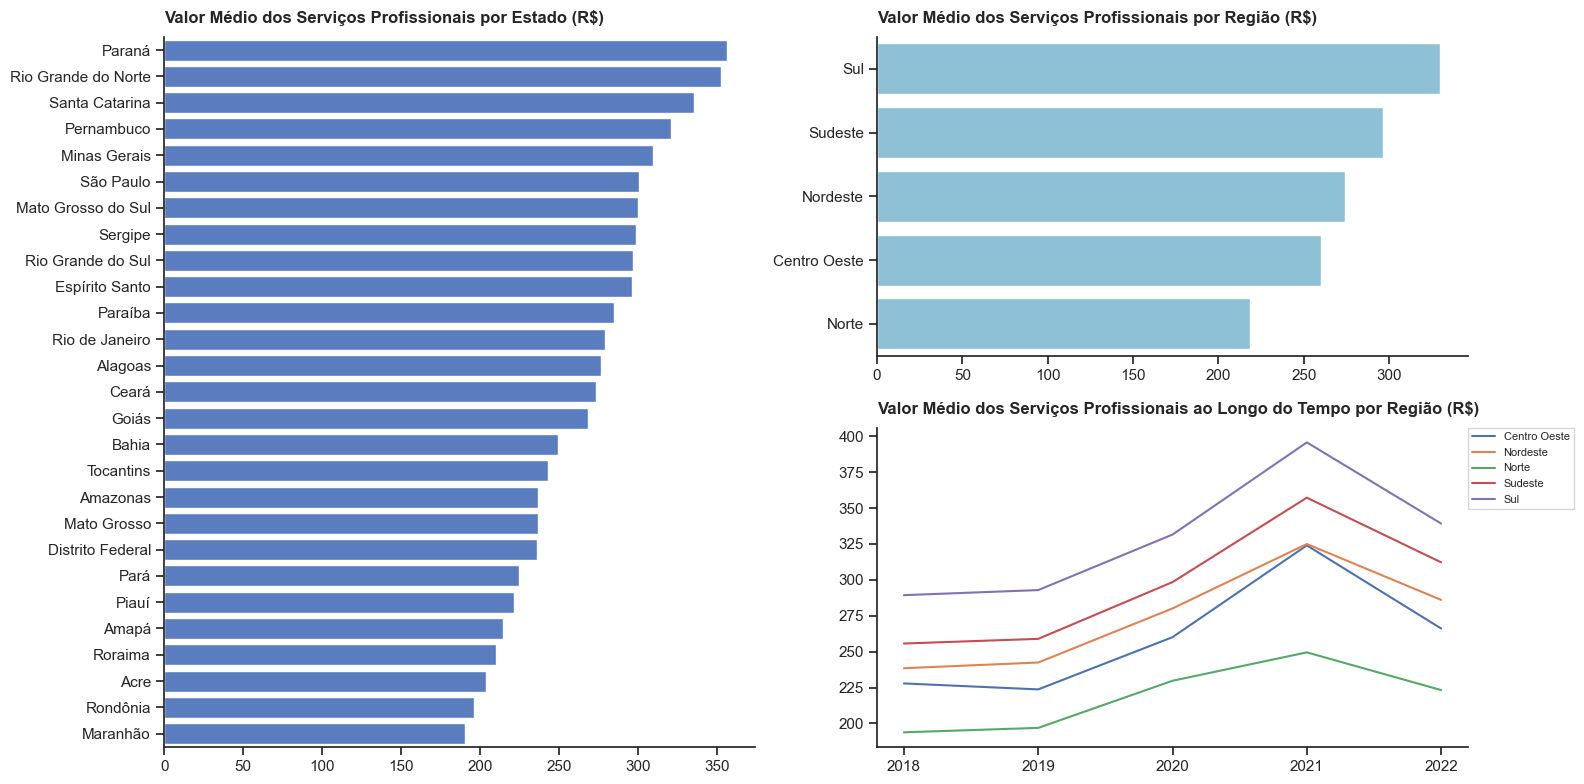

In [376]:
fig5, ax5 = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), constrained_layout=True)

plt.subplot(2, 2, (1,3))
aux1 = df1[['uf', 'valor_servicos_profissionais', 'frequencia_internacoes']]
aux1['valor_serv_prof_internacao'] = aux1['valor_servicos_profissionais'] / aux1['frequencia_internacoes']
aux1 = aux1.groupby('uf').mean().sort_values(by='valor_serv_prof_internacao', ascending=False).reset_index()
sns.barplot(x='valor_serv_prof_internacao', y='uf', data=aux1, color='b')
plt.title('Valor Médio dos Serviços Profissionais por Estado (R$)', fontsize=12, loc='left', pad=10)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 2)
aux2 = df1[['regiao', 'valor_servicos_profissionais', 'frequencia_internacoes']]
aux2['valor_serv_prof_internacao'] = aux2['valor_servicos_profissionais'] / aux2['frequencia_internacoes']
aux2 = aux2.groupby('regiao').mean().sort_values(by='valor_serv_prof_internacao', ascending=False).reset_index()
sns.barplot(x='valor_serv_prof_internacao', y='regiao', data=aux2, color='c')
plt.title('Valor Médio dos Serviços Profissionais por Região (R$)', fontsize=12, loc='left', pad=10)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 4)
aux3 = df1[['ano', 'regiao', 'valor_servicos_profissionais', 'frequencia_internacoes']]
aux3['valor_serv_prof_internacao'] = aux3['valor_servicos_profissionais'] / aux3['frequencia_internacoes']
aux3 = aux3.groupby(['ano', 'regiao']).mean().sort_values(by='ano', ascending=True).reset_index()
sns.lineplot(x='ano', y='valor_serv_prof_internacao', hue='regiao', data=aux3)
plt.title('Valor Médio dos Serviços Profissionais ao Longo do Tempo por Região (R$)', fontsize=12, loc='left', pad=10)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('')
plt.ylabel('')

plt.tight_layout()
plt.show()

#### Valor Total Pago em Complemento Gestor por Estado

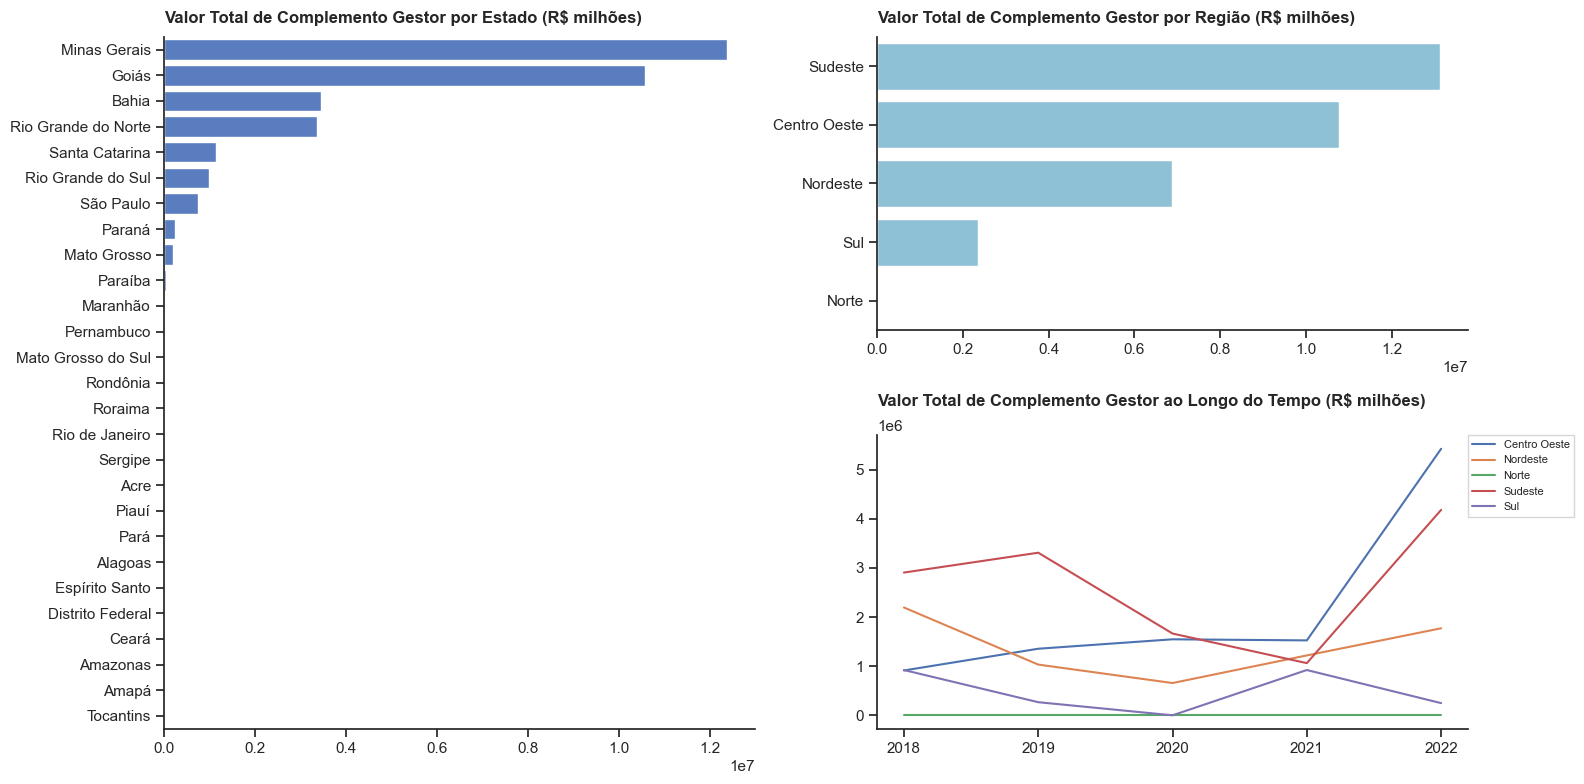

In [377]:
df1['complemento_federal'] = df1['val_serv_hosp_compl_federal'] + df1['val_serv_prof_compl_federal']
df1['complemento_gestor'] = df1['val_serv_hosp_compl_gestor'] + df1['val_serv_prof_compl_gestor']

fig3, ax3 = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), constrained_layout=True)

plt.subplot(2, 2, (1,3))
aux1 = df1[['uf', 'complemento_gestor']].groupby('uf').sum().sort_values(by='complemento_gestor', ascending=False).reset_index()
sns.barplot(x='complemento_gestor', y='uf', data=aux1, color='b')
plt.title('Valor Total de Complemento Gestor por Estado (R$ milhões)', fontsize=12, loc='left', pad=10)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 2)
aux2 = df1[['regiao', 'complemento_gestor']].groupby('regiao').sum().sort_values(by='complemento_gestor', ascending=False).reset_index()
sns.barplot(x='complemento_gestor', y='regiao', data=aux2, color='c')
plt.title('Valor Total de Complemento Gestor por Região (R$ milhões)', fontsize=12, loc='left', pad=10)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 4)
aux3 = df1[['ano', 'valor_total', 'complemento_gestor', 'regiao']].groupby(['ano', 'regiao']).sum().sort_values(by='ano', ascending=True).reset_index()
sns.lineplot(x='ano', y='complemento_gestor', hue='regiao', data=aux3)
plt.title('Valor Total de Complemento Gestor ao Longo do Tempo (R$ milhões)', fontsize=12, loc='left', pad=10)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('')
plt.ylabel('')

plt.tight_layout()
plt.show()

#### Valor Total Pago em Complemento Federal por Estado

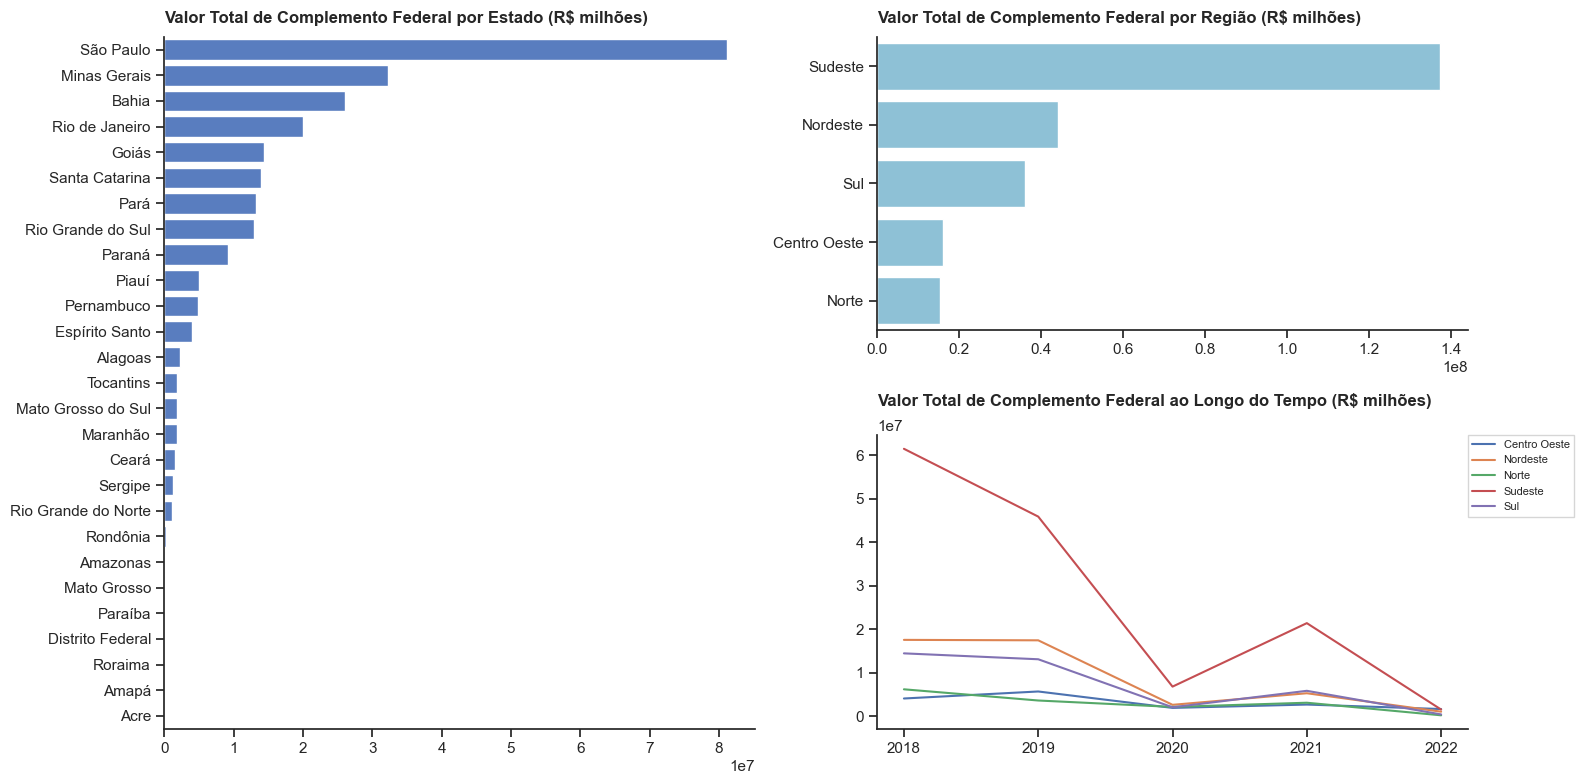

In [378]:
fig3, ax3 = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), constrained_layout=True)

plt.subplot(2, 2, (1,3))
aux1 = df1[['uf', 'complemento_federal']].groupby('uf').sum().sort_values(by='complemento_federal', ascending=False).reset_index()
sns.barplot(x='complemento_federal', y='uf', data=aux1, color='b')
plt.title('Valor Total de Complemento Federal por Estado (R$ milhões)', fontsize=12, loc='left', pad=10)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 2)
aux2 = df1[['regiao', 'complemento_federal']].groupby('regiao').sum().sort_values(by='complemento_federal', ascending=False).reset_index()
sns.barplot(x='complemento_federal', y='regiao', data=aux2, color='c')
plt.title('Valor Total de Complemento Federal por Região (R$ milhões)', fontsize=12, loc='left', pad=10)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 4)
aux3 = df1[['ano', 'valor_total', 'complemento_federal', 'regiao']].groupby(['ano', 'regiao']).sum().sort_values(by='ano', ascending=True).reset_index()
sns.lineplot(x='ano', y='complemento_federal', hue='regiao', data=aux3)
plt.title('Valor Total de Complemento Federal ao Longo do Tempo (R$ milhões)', fontsize=12, loc='left', pad=10)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('')
plt.ylabel('')

plt.tight_layout()
plt.show()

#### Valor médio de internações por Estado

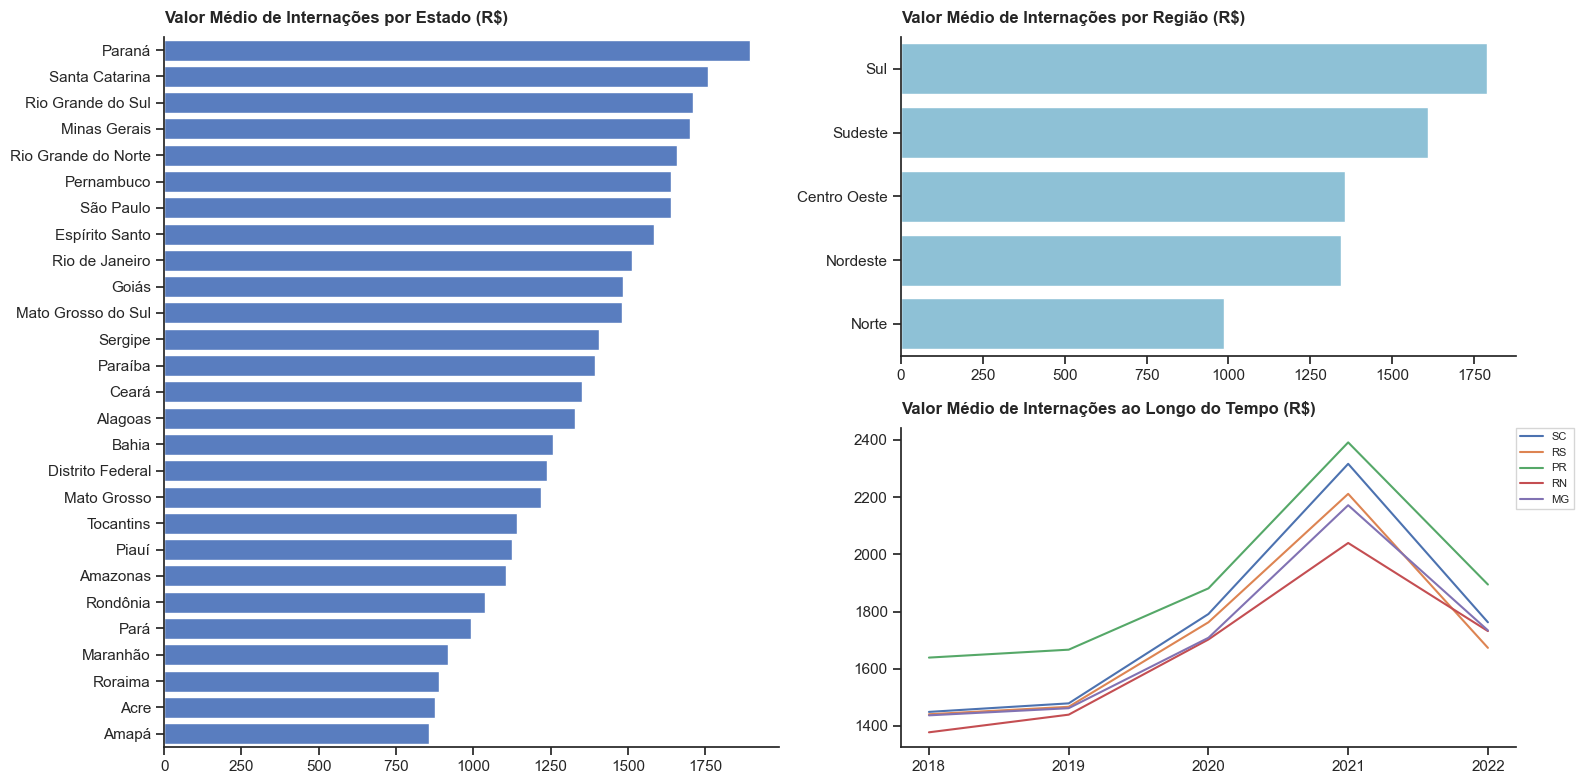

In [379]:
fig4, ax4 = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), constrained_layout=True)

plt.subplot(2, 2, (1,3))
aux1 = df1[['valor_medio_internacao', 'uf']].groupby('uf').mean().sort_values(by='valor_medio_internacao', ascending=False).reset_index()
sns.barplot(y='uf', x='valor_medio_internacao', data=aux1, color='b')
plt.title('Valor Médio de Internações por Estado (R$)', fontsize=12, loc='left', pad=10)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 2)
aux2 = df1[['valor_medio_internacao', 'regiao']].groupby('regiao').mean().sort_values(by='valor_medio_internacao', ascending=False).reset_index()
sns.barplot(x='valor_medio_internacao', y='regiao', data=aux2, color='c')
plt.title('Valor Médio de Internações por Região (R$)', fontsize=12, loc='left', pad=10)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 4)
aux3 = df1[['ano', 'valor_medio_internacao', 'sigla_uf']].groupby(['ano', 'sigla_uf']).mean().sort_values(by='ano', ascending=True).reset_index()
aux3 = aux3[aux3['sigla_uf'].isin(['PR', 'SC', 'RS', 'MG', 'RN'])]
sns.lineplot(x='ano', y='valor_medio_internacao', hue='sigla_uf', data=aux3)
plt.title('Valor Médio de Internações ao Longo do Tempo (R$)', fontsize=12, loc='left', pad=10)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('')
plt.ylabel('')

plt.tight_layout()
plt.show()

#### Tempo médio de permanência em internação

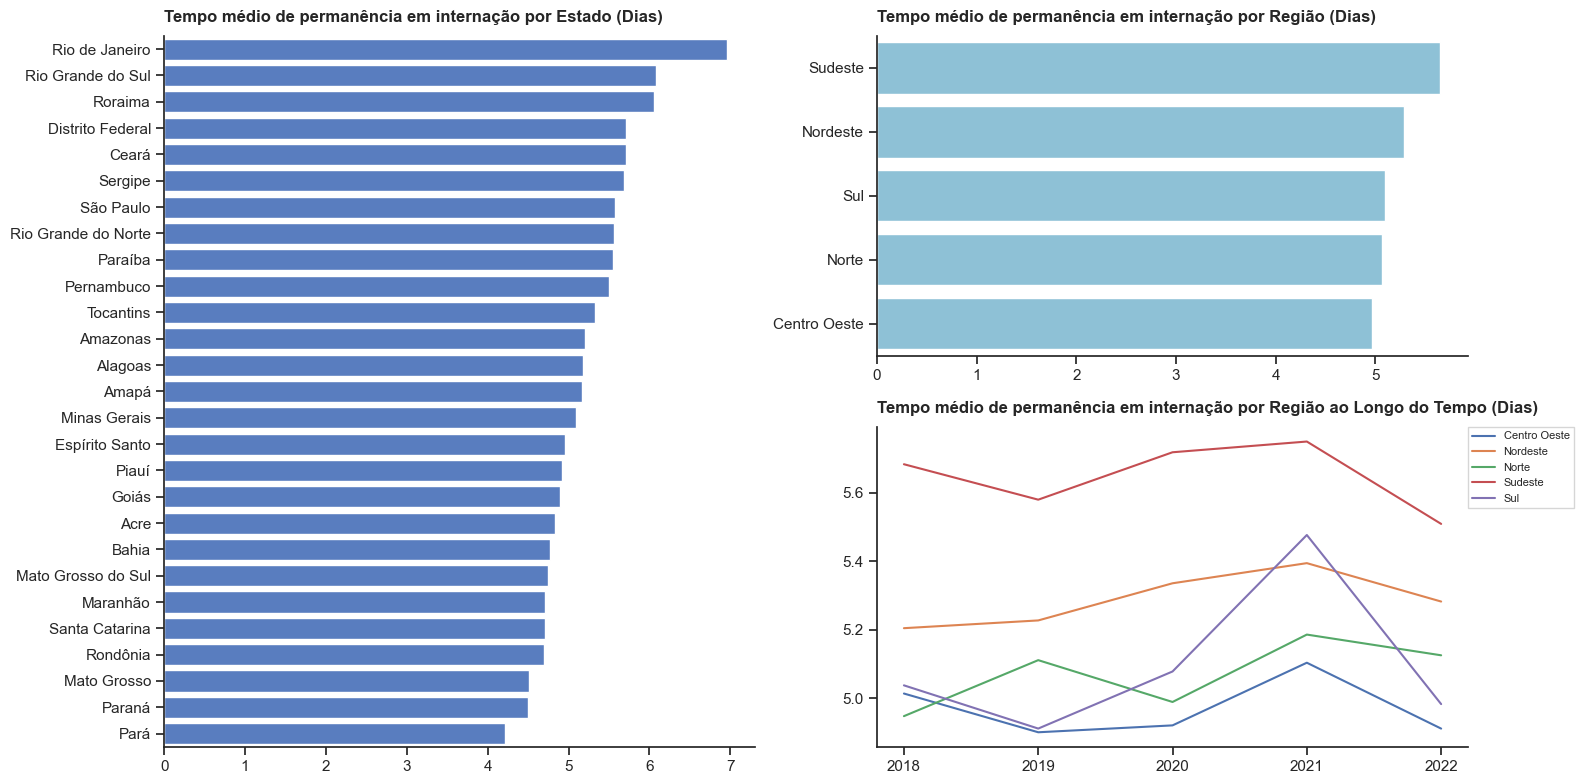

In [380]:
fig7, ax7 = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), constrained_layout=True)

plt.subplot(2, 2, (1,3))
aux1 = df1[['uf', 'media_permanencia']].groupby('uf').mean().sort_values(by='media_permanencia', ascending=False).reset_index()
sns.barplot(x='media_permanencia', y='uf', data=aux1, color='b')
plt.title('Tempo médio de permanência em internação por Estado (Dias)', fontsize=12, loc='left', pad=10)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 2)
aux2 = df1[['regiao', 'media_permanencia']].groupby('regiao').mean().sort_values(by='media_permanencia', ascending=False).reset_index()
sns.barplot(x='media_permanencia', y='regiao', data=aux2, color='c')
plt.title('Tempo médio de permanência em internação por Região (Dias)', fontsize=12, loc='left', pad=10)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 4)
aux3 = df1[['ano', 'regiao', 'media_permanencia']].groupby(['ano', 'regiao']).mean().sort_values(by='ano', ascending=True).reset_index()
sns.lineplot(x='ano', y='media_permanencia', hue='regiao', data=aux3)
plt.title('Tempo médio de permanência em internação por Região ao Longo do Tempo (Dias)', fontsize=12, loc='left', pad=10)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('')
plt.ylabel('')
    
plt.tight_layout()
plt.show()

#### Número médio de leitos ocupados

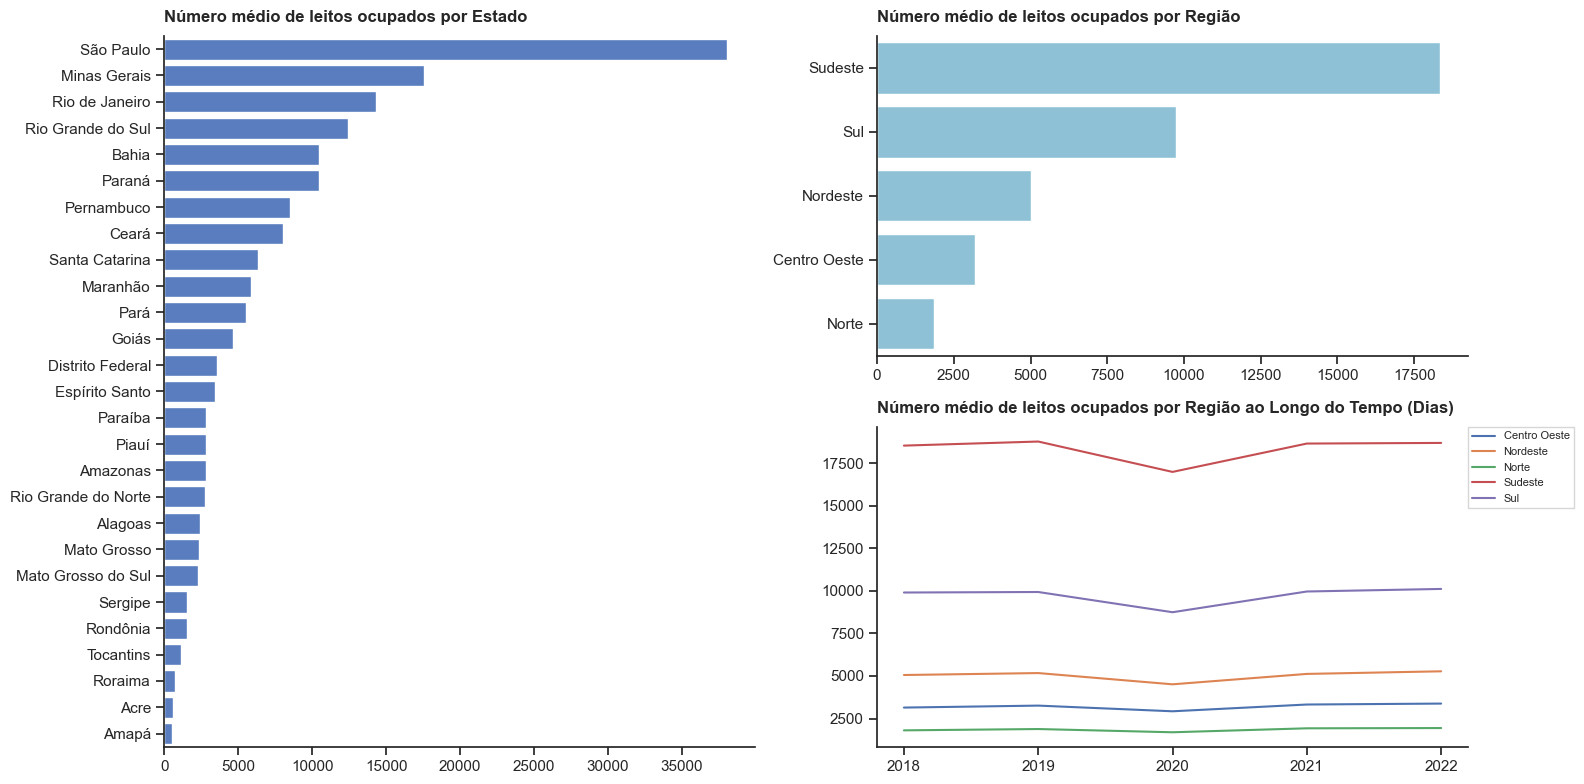

In [381]:
fig7, ax7 = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), constrained_layout=True)

plt.subplot(2, 2, (1,3))
aux1 = df1[['uf', 'no_leitos_ocupados']].groupby('uf').mean().sort_values(by='no_leitos_ocupados', ascending=False).reset_index()
sns.barplot(x='no_leitos_ocupados', y='uf', data=aux1, color='b')
plt.title('Número médio de leitos ocupados por Estado', fontsize=12, loc='left', pad=10)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 2)
aux2 = df1[['regiao', 'no_leitos_ocupados']].groupby('regiao').mean().sort_values(by='no_leitos_ocupados', ascending=False).reset_index()
sns.barplot(x='no_leitos_ocupados', y='regiao', data=aux2, color='c')
plt.title('Número médio de leitos ocupados por Região', fontsize=12, loc='left', pad=10)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 4)
aux3 = df1[['ano', 'regiao', 'no_leitos_ocupados']].groupby(['ano', 'regiao']).mean().sort_values(by='ano', ascending=True).reset_index()
sns.lineplot(x='ano', y='no_leitos_ocupados', hue='regiao', data=aux3)
plt.title('Número médio de leitos ocupados por Região ao Longo do Tempo (Dias)', fontsize=12, loc='left', pad=10)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('')
plt.ylabel('')

plt.tight_layout()
plt.show()

#### Número médio de leitos ocupados por habitantes

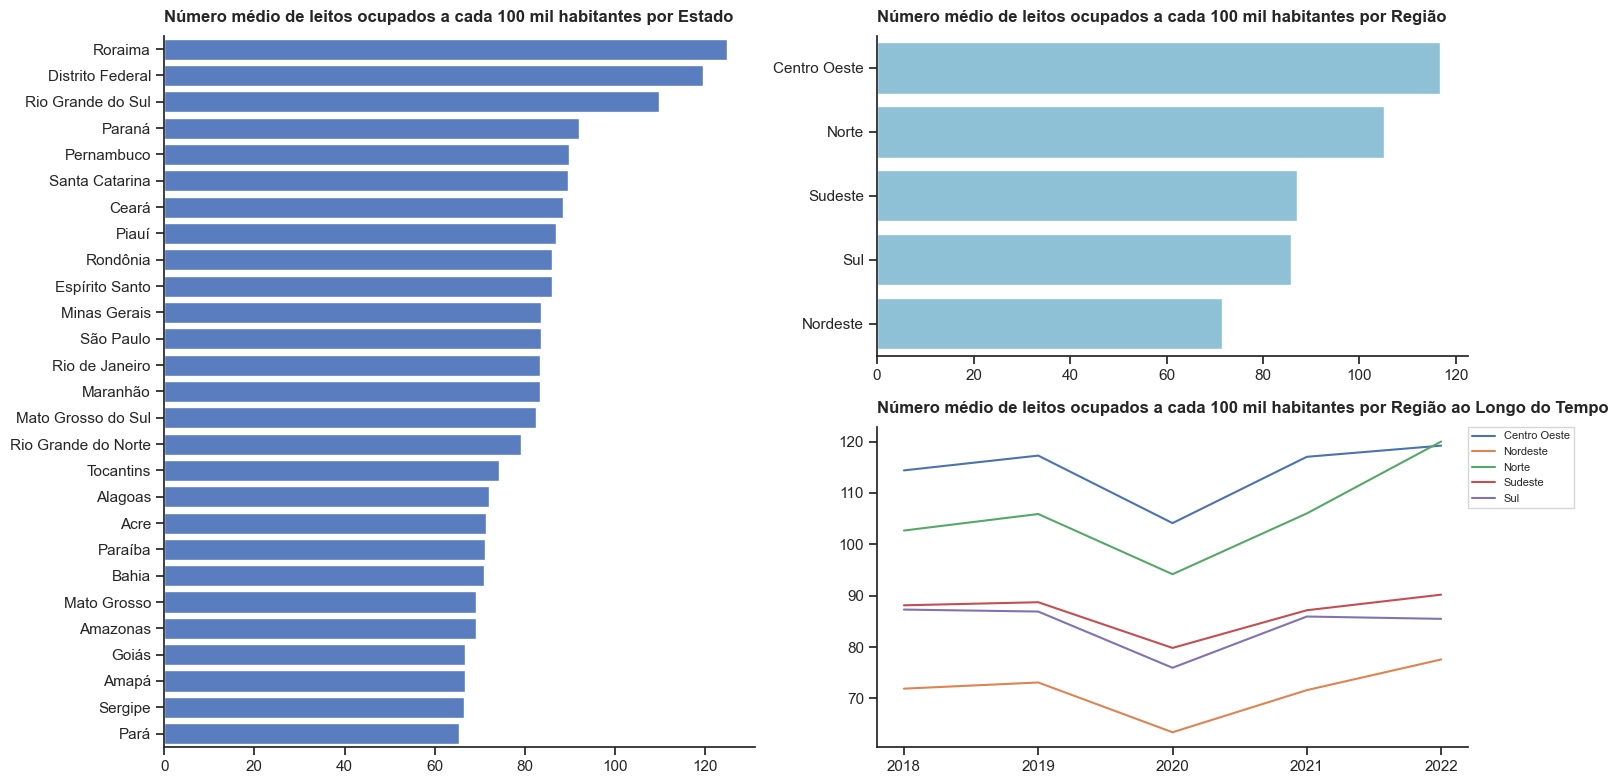

In [382]:
fig7, ax7 = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), constrained_layout=True)

aux = lambda group: (group['no_leitos_ocupados'].mean() / group['populacao'].iloc[0]) * 100000

plt.subplot(2, 2, (1,3))
aux1 = df1.groupby('uf').apply(aux).reset_index(name='no_leitos_pop')
aux1 = aux1.sort_values(by='no_leitos_pop', ascending=False)

sns.barplot(x='no_leitos_pop', y='uf', data=aux1, color='b')
plt.title('Número médio de leitos ocupados a cada 100 mil habitantes por Estado', fontsize=12, loc='left', pad=10)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 2)
aux2 = df1.groupby('regiao').apply(aux).reset_index(name='no_leitos_pop')
aux2 = aux2.sort_values(by='no_leitos_pop', ascending=False)

sns.barplot(x='no_leitos_pop', y='regiao', data=aux2, color='c')
plt.title('Número médio de leitos ocupados a cada 100 mil habitantes por Região', fontsize=12, loc='left', pad=10)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 4)
aux3 = df1.groupby(['ano', 'regiao']).apply(aux).reset_index(name='no_leitos_pop')
aux3 = aux3.sort_values(by='ano', ascending=True)

sns.lineplot(x='ano', y='no_leitos_pop', hue='regiao', data=aux3)
plt.title('Número médio de leitos ocupados a cada 100 mil habitantes por Região ao Longo do Tempo', fontsize=12, loc='left', pad=10)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('')
plt.ylabel('')

plt.tight_layout()
plt.show()

#### Taxa de mortalidade

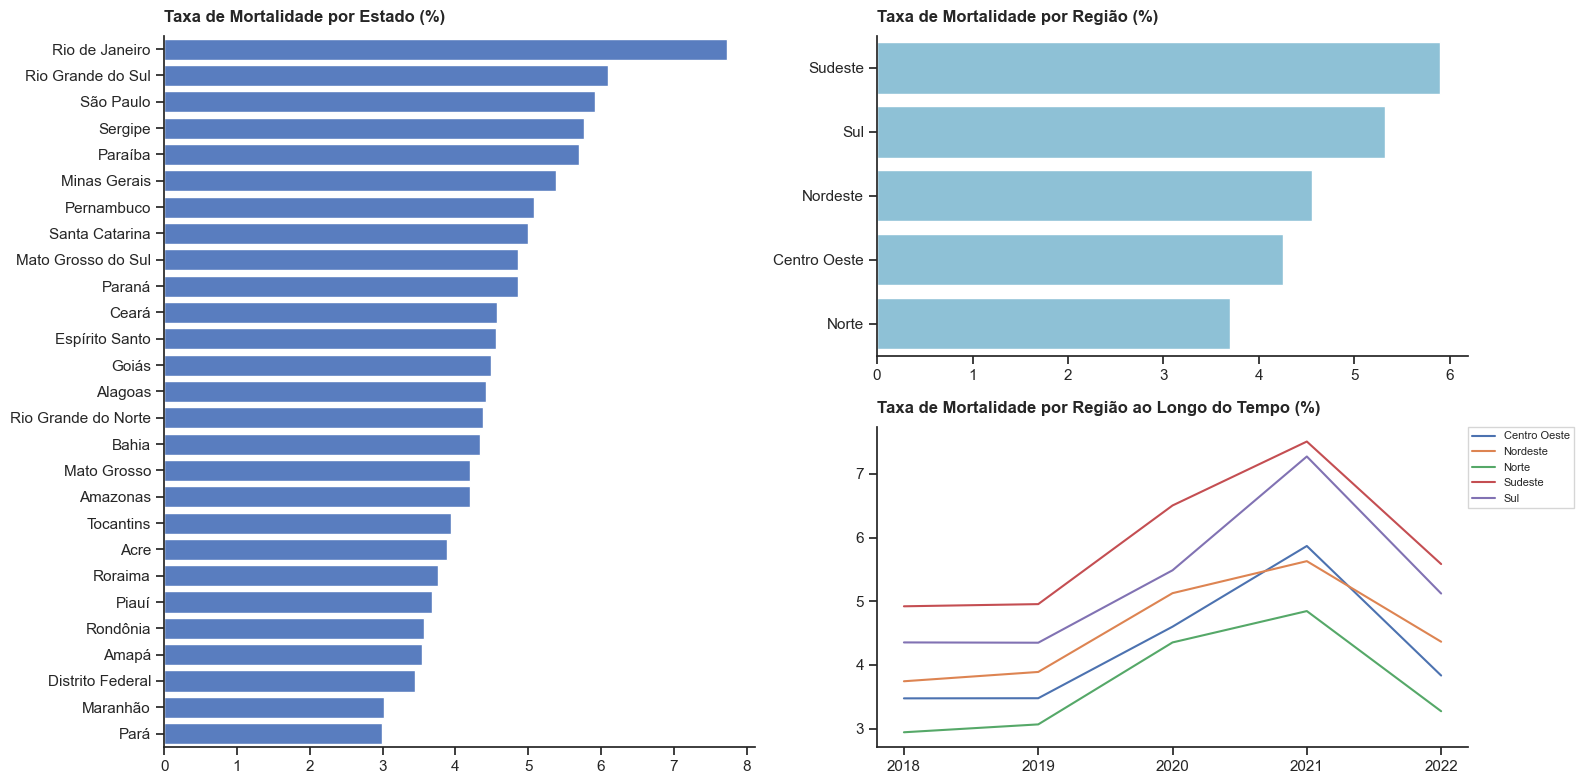

In [383]:
fig8, ax8 = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), constrained_layout=True)

plt.subplot(2, 2, (1,3))
aux1 = df1[['uf', 'taxa_mortalidade']].groupby('uf').mean().sort_values(by='taxa_mortalidade', ascending=False).reset_index()
sns.barplot(x='taxa_mortalidade', y='uf', data=aux1, color='b')
plt.title('Taxa de Mortalidade por Estado (%)', fontsize=12, loc='left', pad=10)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 2)
aux2 = df1[['regiao', 'taxa_mortalidade']].groupby('regiao').mean().sort_values(by='taxa_mortalidade', ascending=False).reset_index()
sns.barplot(x='taxa_mortalidade', y='regiao', data=aux2, color='c')
plt.title('Taxa de Mortalidade por Região (%)', fontsize=12, loc='left', pad=10)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 4)
aux3 = df1[['ano', 'regiao', 'taxa_mortalidade']].groupby(['ano', 'regiao']).mean().sort_values(by='ano', ascending=True).reset_index()
sns.lineplot(x='ano', y='taxa_mortalidade', hue='regiao', data=aux3)
plt.title('Taxa de Mortalidade por Região ao Longo do Tempo (%)', fontsize=12, loc='left', pad=10)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('')
plt.ylabel('')

plt.tight_layout()
plt.show()

### Principais Insights

* Durante os anos de 2018 a 2022, São Paulo liderou os gastos em internações, refletindo a alta concentração de gastos nesse estado, que faz parte da região Sudeste. A região Sudeste, por ser a mais populosa do país, concentra mais de 50% dos gastos totais em internações no Brasil.

* A região Sul se destaca pelo maior valor médio gasto por internação, principalmente no Paraná.

* A região Sudeste lidera em repasses de gestão, com Minas Gerais concentrando a maior parte desses repasses, consolidando a posição da região como líder nesse aspecto. Além disso, o estado de Goiás contribui significativamente para os números da região Centro-Oeste.

* Novamente, a região Sudeste se destaca com os maiores repasses de complemento federal para pagamentos de serviços hospitalares e profissionais de saúde, excedendo em muito os repasses feitos para outras regiões, em especial no ano de 2018. 

* O valor médio gasto por internação é mais alto na região Sul, particularmente no Paraná.

* A região Sudeste, especialmente o Rio de Janeiro, mostra um tempo médio de permanência mais longo em internações. Houve um aumento geral no tempo de permanência em todas as regiões no ano de 2021, em comparação com anos anteriores.

* A região Centro-Oeste lidera em número de leitos ocupados por 100 mil habitantes, seguida pela região Norte, com destaque para Roraima, que se destaca com o maior número de leitos ocupados por habitante.

* A região Sudeste, principalmente o Rio de Janeiro, apresenta a maior taxa de mortalidade entre as regiões analisadas.

#### Conclusões

Com base nos insights da análise exploratória dos dados relacionados aos gastos e métricas de saúde por região e estado, algumas conclusões podem ser extraídas:

*Regionalização dos Gastos em Saúde:* A região Sudeste, impulsionada por São Paulo, lidera em gastos com internações e repasses, refletindo a alta densidade populacional e a concentração de recursos de saúde nessa área.

*Diferenças Regionais nos Gastos e Eficiência:* A região Sul, com destaque para o Paraná, tem um valor médio mais alto gasto por internação, sugerindo variações na eficiência dos gastos em saúde entre as regiões.

*Concentração de Recursos e Repasses:* Os repasses de gestão e complemento federal são mais concentrados na região Sudeste, com Minas Gerais se destacando nesses repasses. Isso pode indicar uma necessidade de redistribuição mais equitativa de recursos para outras regiões.

*Peculiaridades Locais:* Estados como Rio de Janeiro e Roraima têm características específicas, como um tempo médio de permanência mais longo em internações (Rio de Janeiro) e um número significativo de leitos ocupados por habitante (Roraima).

*Desafios de Saúde Pública:* A alta taxa de mortalidade no Rio de Janeiro destaca desafios de saúde específicos nessa região, possivelmente exigindo intervenções mais focadas e recursos adicionais.

*Tendências Temporais:* O aumento do tempo médio de permanência em 2021 em todas as regiões pode indicar mudanças nos padrões de cuidados de saúde, possíveis impactos da pandemia ou outras variáveis a serem investigadas.


Essas conclusões ressaltam a importância de uma análise detalhada e regionalizada para compreender melhor as disparidades nos gastos com saúde, identificar áreas de atenção prioritária e direcionar recursos de maneira mais eficaz para melhorar os sistemas de saúde em diferentes regiões do país.

### Projeções para os próximos seis meses

#### Preparação dos dados

In [623]:
# Base de dados valor meédio de internações mensal
df2 = df1[['data', 'frequencia_internacoes', 'obitos', 'dias_permanencia', 'no_leitos_ocupados', 'valor_total']].groupby('data').sum().reset_index()
df2['valor_medio_internacao'] = df1['valor_medio_internacao'].groupby(df1['data']).mean().reset_index()['valor_medio_internacao']

df2.head()

,data,frequencia_internacoes,obitos,dias_permanencia,no_leitos_ocupados,valor_total,valor_medio_internacao
0,2018-01-01,968989,41764,5141488,171382.93,1218528578.16,1116.88
1,2018-02-01,930092,38612,4925746,164191.53,1160580637.71,1109.12
2,2018-03-01,1010157,40490,5236604,174553.47,1249570771.57,1104.23
3,2018-04-01,1022183,41111,5305641,176854.70,1265569345.19,1099.85
4,2018-05-01,1034183,42508,5392075,179735.83,1279917419.73,1089.78


#### Previsão do valor total

In [574]:
# Preparar os dados
data = df2['data'].values.reshape(-1, 1)
valor_total = df2['valor_total'].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(valor_total)

In [575]:
# Dividir os dados em treino e teste
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

In [576]:
# Preparação dos dados para a LSTM
def create_dataset(dataset, time_step=1):
    data_x, data_y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        data_x.append(a)
        data_y.append(dataset[i + time_step, 0])
    return np.array(data_x), np.array(data_y)

time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reformular os dados para o formato esperado pelo LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [577]:
# Construir o modelo LSTM
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=64))
model.add(Dropout(0.3))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, kernel_regularizer=regularizers.l2(0.001)))

optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Treinar o modelo com os novos hiperparâmetros
model.fit(X_train, y_train, epochs=150, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/150
1/1 [==============================] - 5s 5s/step - loss: 0.1947 - mae: 0.3467 - val_loss: 0.1325 - val_mae: 0.3613
Epoch 2/150
1/1 [==============================] - 0s 52ms/step - loss: 0.1904 - mae: 0.3411 - val_loss: 0.1285 - val_mae: 0.3557
Epoch 3/150
1/1 [==============================] - 0s 53ms/step - loss: 0.1877 - mae: 0.3394 - val_loss: 0.1246 - val_mae: 0.3501
Epoch 4/150
1/1 [==============================] - 0s 53ms/step - loss: 0.1845 - mae: 0.3345 - val_loss: 0.1206 - val_mae: 0.3445
Epoch 5/150
1/1 [==============================] - 0s 50ms/step - loss: 0.1807 - mae: 0.3318 - val_loss: 0.1168 - val_mae: 0.3388
Epoch 6/150
1/1 [==============================] - 0s 51ms/step - loss: 0.1822 - mae: 0.3306 - val_loss: 0.1130 - val_mae: 0.3331
Epoch 7/150
1/1 [==============================] - 0s 51ms/step - loss: 0.1742 - mae: 0.3234 - val_loss: 0.1092 - val_mae: 0.3275
Epoch 8/150
1/1 [==============================] - 0s 54ms/step - loss: 0.1735 - mae: 0.3216

In [578]:
# Avaliar o modelo
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transformar os dados de volta ao formato original
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

1/1 [==============================] - 0s 26ms/step


In [579]:
# Calcular o RMSE (Root Mean Squared Error)
rmse_train = np.sqrt(mean_squared_error(y_train, train_predict))
rmse_test = np.sqrt(mean_squared_error(y_test, test_predict))

print(f"RMSE (Root Mean Squared Error) para os dados de treino: {rmse_train:.2f}")
print(f"RMSE (Root Mean Squared Error) para os dados de teste: {rmse_test:.2f}")

RMSE (Root Mean Squared Error) para os dados de treino: 1519780252.83
RMSE (Root Mean Squared Error) para os dados de teste: 1680421631.64


In [580]:
# Previsões para os próximos seis meses
forecast_steps = 6 
forecast_values = []

current_data = test_data[-time_step:].reshape(1, time_step, 1)

for i in range(forecast_steps):
    predicted_value = model.predict(current_data)[0][0]
    
    forecast_values.append(predicted_value)
    
    current_data = np.roll(current_data, -1)
    current_data[0, time_step - 1, 0] = predicted_value

forecast = scaler.inverse_transform(np.array(forecast_values).reshape(-1, 1))

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step


In [581]:
# Criar datas para os seis meses previstos
dates = pd.date_range(start=df2['data'].max(), periods=forecast_steps + 1, freq='MS')[1:]
df_valor_total = pd.DataFrame({'Data': dates, 'Valor Total': forecast.flatten()})

df_valor_total

,Data,Valor Total
0,2023-01-01,1686443008.00
1,2023-02-01,1692918528.00
2,2023-03-01,1706663680.00
3,2023-04-01,1719030400.00
4,2023-05-01,1739806976.00
5,2023-06-01,1751025152.00


#### Previsão do valor médio de internações

In [582]:
data_valor_medio = df2['data'].values.reshape(-1, 1)
valor_medio = df2['valor_medio_internacao'].values.reshape(-1, 1)

scaler_valor_medio = MinMaxScaler()
scaled_valor_medio = scaler_valor_medio.fit_transform(valor_medio)

In [583]:
# Dividir os dados em treino e teste
train_size_valor_medio= int(len(scaled_valor_medio) * 0.8)
test_size_valor_medio = len(scaled_valor_medio) - train_size_valor_medio
train_data_valor_medio, test_data_valor_medio = scaled_valor_medio[0:train_size_valor_medio, :], scaled_valor_medio[train_size_valor_medio:len(scaled_valor_medio), :]

# Criar conjunto de dados
time_step_medio = 10
X_train_medio, y_train_medio = create_dataset(train_data_valor_medio, time_step_medio)
X_test_medio, y_test_medio = create_dataset(test_data_valor_medio, time_step_medio)

# Reformular os dados para o formato esperado pelo LSTM [amostras, time steps, features]
X_train_medio = X_train_medio.reshape(X_train_medio.shape[0], X_train_medio.shape[1], 1)
X_test_medio = X_test_medio.reshape(X_test_medio.shape[0], X_test_medio.shape[1], 1)

In [584]:
# Construir o modelo LSTM
model_medio = Sequential()
model_medio.add(LSTM(units=128, return_sequences=True, input_shape=(X_train_medio.shape[1], X_train_medio.shape[2])))
model_medio.add(Dropout(0.3))
model_medio.add(LSTM(units=128))
model_medio.add(Dropout(0.3))
model_medio.add(Dense(units=32, activation='relu'))
model_medio.add(Dense(units=1, kernel_regularizer=regularizers.l2(0.001)))

optimizer = Adam(lr=0.0001)
model_medio.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Treinar o modelo
model_medio.fit(X_train_medio, y_train_medio, epochs=150, batch_size=64, validation_data=(X_test_medio, y_test_medio))

Epoch 1/150
1/1 [==============================] - 11s 11s/step - loss: 0.2175 - mae: 0.3435 - val_loss: 0.1049 - val_mae: 0.3214
Epoch 2/150
1/1 [==============================] - 0s 85ms/step - loss: 0.2167 - mae: 0.3419 - val_loss: 0.1017 - val_mae: 0.3165
Epoch 3/150
1/1 [==============================] - 0s 90ms/step - loss: 0.2069 - mae: 0.3337 - val_loss: 0.0987 - val_mae: 0.3116
Epoch 4/150
1/1 [==============================] - 0s 83ms/step - loss: 0.2067 - mae: 0.3318 - val_loss: 0.0957 - val_mae: 0.3067
Epoch 5/150
1/1 [==============================] - 0s 82ms/step - loss: 0.2033 - mae: 0.3280 - val_loss: 0.0926 - val_mae: 0.3018
Epoch 6/150
1/1 [==============================] - 0s 98ms/step - loss: 0.1979 - mae: 0.3229 - val_loss: 0.0896 - val_mae: 0.2967
Epoch 7/150
1/1 [==============================] - 0s 116ms/step - loss: 0.1940 - mae: 0.3189 - val_loss: 0.0867 - val_mae: 0.2917
Epoch 8/150
1/1 [==============================] - 0s 127ms/step - loss: 0.1925 - mae: 0.

In [585]:
# Avaliar o modelo
train_predict = model_medio.predict(X_train_medio)
test_predict = model_medio.predict(X_test_medio)

# Transformar os dados de volta ao formato original
train_predict = scaler_valor_medio.inverse_transform(train_predict)
test_predict = scaler_valor_medio.inverse_transform(test_predict)

1/1 [==============================] - 0s 26ms/step


In [586]:
# Calcular RMSE para os dados de treinamento e teste
rmse_train = np.sqrt(mean_squared_error(y_train_medio, train_predict))
rmse_test = np.sqrt(mean_squared_error(y_test_medio, test_predict))

print(f"RMSE (Root Mean Squared Error) para os dados de treino: {rmse_train:.2f}")
print(f"RMSE (Root Mean Squared Error) para os dados de teste: {rmse_test:.2f}")

RMSE (Root Mean Squared Error) para os dados de treino: 1417.63
RMSE (Root Mean Squared Error) para os dados de teste: 1482.24


In [587]:
# Previsões para os próximos seis meses
forecast_steps = 6
forecast_values = []

current_data = test_data_valor_medio[-time_step_medio:].reshape(1, time_step_medio, 1)

for i in range(forecast_steps):
    predicted_value = model_medio.predict(current_data)[0][0]
    forecast_values.append(predicted_value)
    
    current_data = np.roll(current_data, -1)
    current_data[0, time_step_medio - 1, 0] = predicted_value

# Converter as previsões de volta ao formato original
forecast_medio = scaler_valor_medio.inverse_transform(np.array(forecast_values).reshape(-1, 1))

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


In [588]:
# Criar datas para os seis meses previstos
dates = pd.date_range(start=df2['data'].max(), periods=forecast_steps + 1, freq='MS')[1:]
df_medio = pd.DataFrame({'Data': dates, 'Valor médio': forecast_medio.flatten()})

df_medio

,Data,Valor médio
0,2023-01-01,1462.29
1,2023-02-01,1468.39
2,2023-03-01,1479.31
3,2023-04-01,1496.27
4,2023-05-01,1518.86
5,2023-06-01,1537.48


#### Previsão de internações

In [589]:
data_internacao = df2['data'].values.reshape(-1, 1)
internacao = df2['frequencia_internacoes'].values.reshape(-1, 1)

scaler_internacao = MinMaxScaler()
scaled_internacao = scaler_internacao.fit_transform(internacao)

In [590]:
# Dividir os dados em treino e teste
train_size_inter = int(len(scaled_internacao) * 0.8)
test_size_inter = len(scaled_internacao) - train_size_inter
train_data_inter, test_data_inter = scaled_internacao[0:train_size_inter, :], scaled_internacao[train_size_inter:len(scaled_internacao), :]

# Criar conjunto de dados 
time_step_inter = 10
X_train_inter, y_train_inter = create_dataset(train_data_inter, time_step_inter)
X_test_inter, y_test_inter = create_dataset(test_data_inter, time_step_inter)

# Reformular os dados para o formato esperado pelo LSTM [amostras, time steps, features]
X_train_inter = X_train_inter.reshape(X_train_inter.shape[0], X_train_inter.shape[1], 1)
X_test_inter = X_test_inter.reshape(X_test_inter.shape[0], X_test_inter.shape[1], 1)

In [608]:
# Construir o modelo LSTM
model_inter = Sequential()
model_inter.add(LSTM(units=128, return_sequences=True, input_shape=(X_train_inter.shape[1], X_train_inter.shape[2])))
model_inter.add(Dropout(0.3))
model_inter.add(LSTM(units=64))
model_inter.add(Dropout(0.3))
model_inter.add(Dense(units=32, activation='relu'))
model_inter.add(Dense(units=1, kernel_regularizer=regularizers.l2(0.001)))

optimizer = Adam(lr=0.0001)
model_inter.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Treinar o modelo
model_inter.fit(X_train_inter, y_train_inter, epochs=100, batch_size=32, validation_data=(X_test_inter, y_test_inter))

Epoch 1/100
2/2 [==============================] - 4s 887ms/step - loss: 0.4137 - mae: 0.5922 - val_loss: 0.3560 - val_mae: 0.5953
Epoch 2/100
2/2 [==============================] - 0s 44ms/step - loss: 0.3990 - mae: 0.5800 - val_loss: 0.3373 - val_mae: 0.5793
Epoch 3/100
2/2 [==============================] - 0s 41ms/step - loss: 0.3839 - mae: 0.5673 - val_loss: 0.3203 - val_mae: 0.5645
Epoch 4/100
2/2 [==============================] - 0s 40ms/step - loss: 0.3717 - mae: 0.5599 - val_loss: 0.3090 - val_mae: 0.5544
Epoch 5/100
2/2 [==============================] - 0s 44ms/step - loss: 0.3614 - mae: 0.5513 - val_loss: 0.2985 - val_mae: 0.5448
Epoch 6/100
2/2 [==============================] - 0s 38ms/step - loss: 0.3485 - mae: 0.5392 - val_loss: 0.2874 - val_mae: 0.5345
Epoch 7/100
2/2 [==============================] - 0s 40ms/step - loss: 0.3519 - mae: 0.5416 - val_loss: 0.2757 - val_mae: 0.5235
Epoch 8/100
2/2 [==============================] - 0s 38ms/step - loss: 0.3321 - mae: 0.5

In [609]:
# Avaliar o modelo
train_predict = model_inter.predict(X_train_inter)
test_predict = model_inter.predict(X_test_inter)

# Transformar os dados de volta ao formato original
train_predict = scaler_internacao.inverse_transform(train_predict)
test_predict = scaler_internacao.inverse_transform(test_predict)

1/1 [==============================] - 0s 30ms/step


In [610]:
# Calcular RMSE para os dados de treinamento e teste
rmse_train = np.sqrt(mean_squared_error(y_train_inter, train_predict))
rmse_test = np.sqrt(mean_squared_error(y_test_inter, test_predict))

print(f"RMSE (Root Mean Squared Error) para os dados de treino: {rmse_train:.2f}")
print(f"RMSE (Root Mean Squared Error) para os dados de teste: {rmse_test:.2f}")

RMSE (Root Mean Squared Error) para os dados de treino: 961520.26
RMSE (Root Mean Squared Error) para os dados de teste: 1004688.91


In [611]:
# Previsões para os próximos seis meses
forecast_steps = 6  
forecast_values = []

current_data = test_data_inter[-time_step_inter:].reshape(1, time_step_inter, 1)

for i in range(forecast_steps):
    predicted_value = model_inter.predict(current_data)[0][0]
    forecast_values.append(predicted_value)
    
    current_data = np.roll(current_data, -1)
    current_data[0, time_step_inter - 1, 0] = predicted_value

# Converter as previsões de volta ao formato original
forecast_inter = scaler_internacao.inverse_transform(np.array(forecast_values).reshape(-1, 1))

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


In [612]:
# Criar datas para os seis meses previstos
dates = pd.date_range(start=df2['data'].max(), periods=forecast_steps + 1, freq='MS')[1:]
df_inter = pd.DataFrame({'Data': dates, 'Internações': forecast_inter.flatten()})
df_inter

,Data,Internações
0,2023-01-01,1012818.69
1,2023-02-01,1011632.25
2,2023-03-01,1010843.69
3,2023-04-01,1007615.25
4,2023-05-01,1005502.31
5,2023-06-01,1000600.62


#### Previsão de óbitos

In [613]:
data_obitos = df2['data'].values.reshape(-1, 1)
obitos = df2['obitos'].values.reshape(-1, 1)

scaler_obitos = MinMaxScaler()
scaled_obitos = scaler_obitos.fit_transform(obitos)

In [614]:
# Dividir os dados em treino e teste
train_size_obitos = int(len(scaled_obitos) * 0.8)
test_size_obitos = len(scaled_obitos) - train_size_obitos
train_data_obitos, test_data_obitos = scaled_obitos[0:train_size_obitos, :], scaled_obitos[train_size_obitos:len(scaled_obitos), :]

# Criar conjunto de dados
time_step_obitos = 10
X_train_obitos, y_train_obitos = create_dataset(train_data_obitos, time_step_obitos)
X_test_obitos, y_test_obitos = create_dataset(test_data_obitos, time_step_obitos)

X_train_obitos = X_train_obitos.reshape(X_train_obitos.shape[0], X_train_obitos.shape[1], 1)
X_test_obitos = X_test_obitos.reshape(X_test_obitos.shape[0], X_test_obitos.shape[1], 1)

In [615]:
# Construir o modelo LSTM
model_obitos = Sequential()
model_obitos.add(LSTM(units=128, return_sequences=True, input_shape=(X_train_obitos.shape[1], X_train_obitos.shape[2])))
model_obitos.add(Dropout(0.3))
model_obitos.add(LSTM(units=64))
model_obitos.add(Dropout(0.3))
model_obitos.add(Dense(units=32, activation='relu'))
model_obitos.add(Dense(units=1, kernel_regularizer=regularizers.l2(0.001)))

optimizer = Adam(lr=0.0001)
model_obitos.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Treinar o modelo
model_obitos.fit(X_train_obitos, y_train_obitos, epochs=150, batch_size=64, validation_data=(X_test_obitos, y_test_obitos))

Epoch 1/150
1/1 [==============================] - 6s 6s/step - loss: 0.1454 - mae: 0.2801 - val_loss: 0.0094 - val_mae: 0.0874
Epoch 2/150
1/1 [==============================] - 0s 73ms/step - loss: 0.1483 - mae: 0.2809 - val_loss: 0.0087 - val_mae: 0.0831
Epoch 3/150
1/1 [==============================] - 0s 76ms/step - loss: 0.1450 - mae: 0.2778 - val_loss: 0.0081 - val_mae: 0.0793
Epoch 4/150
1/1 [==============================] - 0s 69ms/step - loss: 0.1413 - mae: 0.2722 - val_loss: 0.0075 - val_mae: 0.0754
Epoch 5/150
1/1 [==============================] - 0s 82ms/step - loss: 0.1358 - mae: 0.2676 - val_loss: 0.0069 - val_mae: 0.0712
Epoch 6/150
1/1 [==============================] - 0s 83ms/step - loss: 0.1373 - mae: 0.2662 - val_loss: 0.0063 - val_mae: 0.0670
Epoch 7/150
1/1 [==============================] - 0s 105ms/step - loss: 0.1344 - mae: 0.2632 - val_loss: 0.0057 - val_mae: 0.0627
Epoch 8/150
1/1 [==============================] - 0s 177ms/step - loss: 0.1353 - mae: 0.26

In [616]:
# Avaliar o modelo
train_predict = model_obitos.predict(X_train_obitos)
test_predict = model_obitos.predict(X_test_obitos)

# Transformar os dados de volta ao formato original
train_predict = scaler_obitos.inverse_transform(train_predict)
test_predict = scaler_obitos.inverse_transform(test_predict)

1/1 [==============================] - 0s 30ms/step


In [617]:
# Calcular RMSE para os dados de treinamento e teste
rmse_train = np.sqrt(mean_squared_error(y_train_obitos, train_predict))
rmse_test = np.sqrt(mean_squared_error(y_test_obitos, test_predict))

print(f"RMSE (Root Mean Squared Error) para os dados de treino: {rmse_train:.2f}")
print(f"RMSE (Root Mean Squared Error) para os dados de teste: {rmse_test:.2f}")

RMSE (Root Mean Squared Error) para os dados de treino: 51964.20
RMSE (Root Mean Squared Error) para os dados de teste: 53901.77


Comparando os resultados do treinamento e teste o modelo está performando razoavelmente bem em ambos.

In [618]:
# Previsões para os próximos seis meses
forecast_steps = 6
forecast_values = []

current_data = test_data_obitos[-time_step_obitos:].reshape(1, time_step_obitos, 1)

for i in range(forecast_steps):
    predicted_value = model_obitos.predict(current_data)[0][0]
    forecast_values.append(predicted_value)
    
    current_data = np.roll(current_data, -1)
    current_data[0, time_step_obitos - 1, 0] = predicted_value

# Converter as previsões de volta ao formato original
forecast_obitos = scaler_obitos.inverse_transform(np.array(forecast_values).reshape(-1, 1))

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


In [619]:
# Criar datas para os seis meses previstos
dates = pd.date_range(start=df2['data'].max(), periods=forecast_steps + 1, freq='MS')[1:]
df_obitos = pd.DataFrame({'Data': dates, 'Óbitos': forecast_obitos.flatten()})
df_obitos

,Data,Óbitos
0,2023-01-01,52235.20
1,2023-02-01,51950.14
2,2023-03-01,52074.60
3,2023-04-01,52205.20
4,2023-05-01,52466.23
5,2023-06-01,52389.11


#### Projeções Finais

In [620]:
# Dataframe final com as previsões
dfs = [df_valor_total, df_inter, df_medio, df_obitos]
df_final = reduce(lambda left, right: pd.merge(left, right, on='Data'), dfs)
df_final['Valor Total'] = df_final['Valor Total'] / 10**9
df_final

,Data,Valor Total,Internações,Valor médio,Óbitos
0,2023-01-01,1.69,1012818.69,1462.29,52235.20
1,2023-02-01,1.69,1011632.25,1468.39,51950.14
2,2023-03-01,1.71,1010843.69,1479.31,52074.60
3,2023-04-01,1.72,1007615.25,1496.27,52205.20
4,2023-05-01,1.74,1005502.31,1518.86,52466.23
5,2023-06-01,1.75,1000600.62,1537.48,52389.11


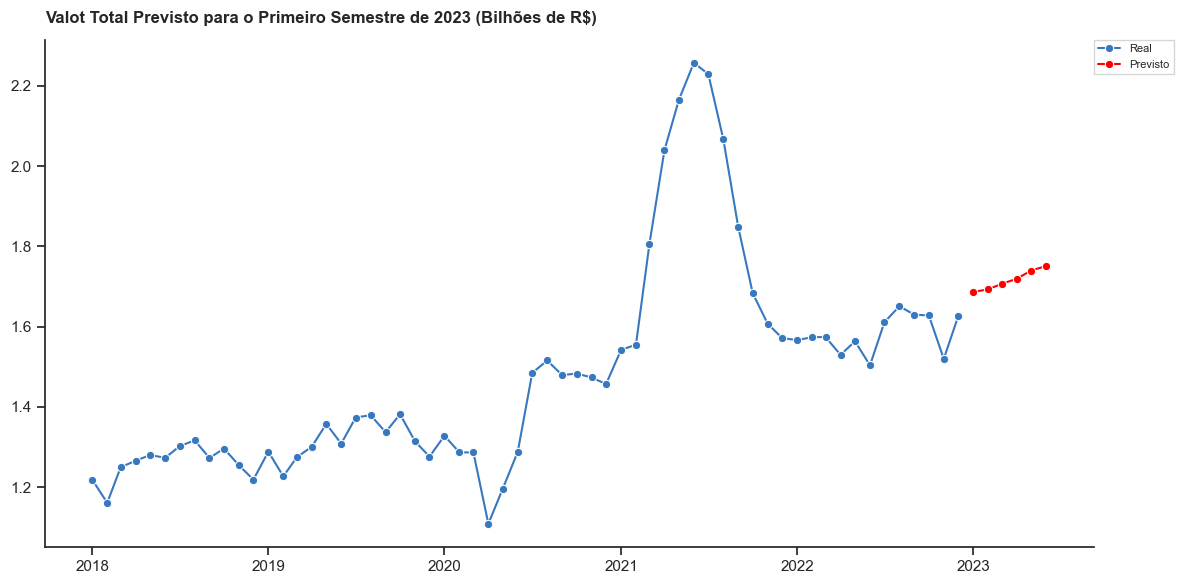

In [624]:
# Visualizção Gráfica - Valor Real x Previsto
real_values_2022 = df2[df2['data'].between('2018-01-01', '2022-12-31')]['valor_total'] / 10**9
real_dates_2022 = df2[df2['data'].between('2018-01-01', '2022-12-31')]['data']

predicted_values_2023 = df_final[df_final['Data'].between('2023-01-01', '2023-06-01')]

real_dates_2022 = pd.to_datetime(real_dates_2022)
predicted_values_2023['Data'] = pd.to_datetime(predicted_values_2023['Data'])


# Gráfico
ax = plt.subplots(figsize=(12, 6), constrained_layout=True)
ax = sns.lineplot(x=real_dates_2022, y=real_values_2022, marker='o', color = sns.xkcd_rgb['windows blue'], label='Real')
ax = sns.lineplot(data=predicted_values_2023, x='Data', y='Valor Total', marker='o', color='red', label='Previsto')

plt.title('Valot Total Previsto para o Primeiro Semestre de 2023 (Bilhões de R$)', fontsize=12, loc='left', pad=12)
plt.xlabel('')
plt.ylabel('')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

### Conclusões

A análise e projeção realizadas forneceram uma compreensão mais profunda dos padrões de internações no Sistema Único de Saúde (SUS). Identificou-se que o Estado de São Paulo se destaca como o maior em gastos com internações no país, evidenciando sua importância no contexto do sistema de saúde brasileiro.

Para futuros avanços, é crucial o refinamento dos modelos visando aprimorar a precisão das previsões. Isso pode envolver a otimização dos algoritmos atuais, a exploração de outros métodos ou a inclusão de variáveis adicionais para fortalecer a robustez dos modelos. 